In [1]:
#pip install pandas matplotlib scipy numpy seaborn 

In [3]:
import copy
import pandas
import warnings
import requests
import scipy
from scipy import stats
import subprocess
import numpy as np
from matplotlib import pyplot as plt
import json
import pprint
import seaborn
import os
import sys
import re

sys.path.insert(0, "../src")
from perf_tools.analysis import make_differential_frame, get_data, get_summary_statistics
from perf_tools.analysis import check_are_close, make_latency_plot, plot_latency_stats

/home/mark/.local/lib/python3.11/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


In [22]:
class YCSBLikeWorkload:
    def __init__(self, workdir, patch_id, variant, execution, task_name, patch_name):
        self.workdir = workdir
        self.patch_id = patch_id
        self.variant = variant
        self.execution = execution
        self.task_name = task_name
        self.patch_name = patch_name
        self.load_data = None
        self.readonly_data = None
        self.updateonly_data = None
        self.evensplit_read_data = None
        self.evensplit_write_data = None
        self.readheavy_read_data = None
        self.readheavy_write_data = None

    def json_path(self, metric):
        return os.path.join(self.workdir, self.patch_id, self.variant,
            self.task_name, str(self.execution), metric + ".json")
    def get_load_data(self):
        if self.load_data is None:
            self.load_data = get_data(self.json_path("YCSBLike.load.inserts"))
        return self.load_data
    def get_100read_data(self):
        if self.readonly_data is None:
            self.readonly_data = get_data(self.json_path("YCSBLike.100read.reads"))
        return self.readonly_data
    def get_100update_data(self):
        if self.updateonly_data is None:
            self.updateonly_data = get_data(self.json_path("YCSBLike.100update.writes"))
        return self.updateonly_data
    # def get_50read50update_data(self):
    #     if self.evensplit_read_data is None:
    #         self.evensplit_read_data = get_data(self.json_path("YCSBLike.50read50update.reads"))
    #     if self.evensplit_write_data is None:
    #         self.evensplit_write_data = get_data(self.json_path("YCSBLike.50read50update.writes"))
    #     return self.evensplit_read_data, self.evensplit_write_data
    def get_95read5update_data(self):
        if self.readheavy_read_data is None:
            self.readheavy_read_data = get_data(self.json_path("YCSBLike.95read5update.reads"))
        if self.readheavy_write_data is None:
            self.readheavy_write_data = get_data(self.json_path("YCSBLike.95read5update.writes"))
        return self.readheavy_read_data, self.readheavy_write_data

    def _plot_line_or_scatter(self, df, x, y, line=False, start=None, end=None, **kwargs):
        if line:
            return df[start:end].plot(x=x, y=y, figsize=(20,20), **kwargs)
        return df[start:end].plot.scatter(x=x, y=y, figsize=(20,20), **kwargs)

    def plot_load_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} load phase insert {y}"
        return self._plot_line_or_scatter(self.get_load_data().diff_data, x, y, line, start, end, title=title, **kwargs)
    def plot_100read_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 100read read {y}"
        return self._plot_line_or_scatter(self.get_100read_data().diff_data, x, y, line, start, end, title=title, **kwargs)
    def plot_100update_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 100update update {y}"
        return self._plot_line_or_scatter(self.get_100update_data().diff_data, x, y, line, start, end, title=title, **kwargs)
    def plot_95read5update_read_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 95read5update read {y}"
        dfr, dfw = self.get_95read5update_data()
        return self._plot_line_or_scatter(dfr.diff_data, x, y, line, start, end, title=title, **kwargs)
    def plot_95read5update_write_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 95read5update update {y}"
        dfr, dfw = self.get_95read5update_data()
        return self._plot_line_or_scatter(dfw.diff_data, x, y, line, start, end, title=title, **kwargs)
    def plot_50read50update_read_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 50read50update read {y}"
        dfr, dfw = self.get_50read50update_data()
        return self._plot_line_or_scatter(dfr.diff_data, x, y, line, start, end, title, **kwargs)
    def plot_50read50update_write_data(self, x, y, line=False, start=None, end=None, **kwargs):
        title=f"{self.variant}-{self.task_name} 50read50update update {y}"
        dfr, dfw = self.get_50read50update_data()
        return self._plot_line_or_scatter(dfw.diff_data, x, y, line, start, end, title, **kwargs)


In [41]:
VARIANTS = {"replset": "linux-1-node-replSet-fle.2022-11", 
            "sharded": "linux-shard-lite-qebench"}
# WORKDIR="../datasets/genny2/fle_ycsblike"

#patch_id = "63e5cf7fd6d80a10530feb40"
patches = [
    ( "63e5cf7fd6d80a10530feb40" , "70", "linux-1-node-replSet-fle.2022-11", "fle_ycsblike"),
    ( "63ea69863066153b5a6ac8e4" , "60", "linux-1-node-replSet-fle.2022-11", "fle_ycsblike60"),
    ( "63ea69767742ae58a875683f" , "unencrypted", "linux-1-node-replSet.2022-11", "fle_ycsblike60_unencrypted"),
]
exec_idx=0
replset_executions = {
    "ycsb_like_queryable_encrypt1_cf16" : [0],
    "ycsb_like_queryable_encrypt1_cf32" : [0],
    "ycsb_like_queryable_encrypt1_cfdefault" : [0],
    "ycsb_like_queryable_encrypt5_cf16" : [0],
    "ycsb_like_queryable_encrypt5_cf32" : [0],
    "ycsb_like_queryable_encrypt5_cfdefault" : [0],
}
# replset_workloads = {
#     task: YCSBLikeWorkload("../datasets/genny2/" + patch[3], patch[0], patch[2], str(replset_executions[task][exec_idx]), task, patch[1])
#     for task in replset_executions.keys()
#     for patch in patches
# }
replset_workloads = [
        YCSBLikeWorkload("../datasets/genny2/" + patch[3], patch[0], patch[2], str(replset_executions[task][exec_idx]), task, patch[1])
    for task in replset_executions.keys()
    for patch in patches
]

# ## 8-thread variation
# replset_8thread_executions = {
#     "genny_qebench_qe_1enc_cf16": [0],
#     "genny_qebench_qe_1enc_cf32": [0],
#     "genny_qebench_qe_1enc_cfdefault": [0],
#     "genny_qebench_qe_5enc_cf16": [0],
#     "genny_qebench_qe_5enc_cf32": [0],
#     "genny_qebench_qe_5enc_cfdefault": [0]
# }
# replset_8thread_workloads = {
#     task: YCSBLikeWorkload(WORKDIR + "_8threads", "6352e6ea61837d2bb04547c1", 
#         VARIANTS["replset"], str(replset_8thread_executions[task][0]), task)
#     for task in replset_8thread_executions.keys()
# }


In [43]:
row="total_ops"
start = None
end = None
pp = pprint.PrettyPrinter()
workloads = replset_workloads
# workloads = sharded_workloads
# workloads = replset_8thread_workloads


In [71]:
def get_summary_statistics_df(wl,task):
    # l1 = wl.get_load_data()
    l1 = wl.get_100read_data()
    b = l1.diff_data
    fixed_data = l1.fixed_data
    raw_data = l1.raw_data

    quantiles = stats.mstats.mquantiles(b.loc[:,"pure_latency"].values, prob=[0.5,0.8,0.9,0.95,0.99], alphap=1/3, betap=1/3)
    averages = b.mean(numeric_only=True)
    maximum = b.max()
    minimum = b.min()
    duration = (b["ts"][len(b)-1] - b["ts"][0]).total_seconds()
    ops = fixed_data["d(ops)"].sum()
    size = fixed_data["d(size)"].sum()
    docs = fixed_data["d(n)"].sum()
    errs = fixed_data["d(err)"].sum()
    overhead = fixed_data["d(t_overhead)"].sum()

    df1 = pandas.DataFrame(index = [0], data = {
        'Task': task,
        "Patch": wl.patch_name,
        'AverageLatency': averages["pure_latency"],
        'AverageLatencyMillis': averages["pure_latency(ms)"],
        'AverageSize': size / ops,
        'OperationThroughput': ops / duration,
        'DocumentThroughput': docs / duration,
        'SizeThroughput': size / duration,
        'ErrorRate': errs / duration,
        'Latency50thPercentile': quantiles[0],
        'Latency80thPercentile': quantiles[1],
        'Latency90thPercentile': quantiles[2],
        'Latency95thPercentile': quantiles[3],
        'Latency99thPercentile': quantiles[4],
        'WorkersMin': raw_data["gauges.workers"].min(),
        'WorkersMax': raw_data["gauges.workers"].max(),
        'LatencyMax': maximum["pure_latency"],
        'LatencyMin': minimum["pure_latency"],
        'DurationTotal': duration * 1e9,
        'ErrorsTotal': errs,
        'OperationsTotal': ops,
        'DocumentsTotal': docs,
        'SizeTotal': size,
        'OverheadTotal': overhead
    })

    return df1
    
re1 = re.compile(r"encrypt(\d)_cf(\d+|default)")

df= None
for wld in workloads:
    task = wld.task_name
    # dfs = wld.get_load_data()
    dfs = wld.get_100read_data()
    title = f"{wld.variant} {wld.task_name} insert stats"

    sdf = get_summary_statistics_df(wld, task)

    m = re1.search(task)
    fields = m.groups(0)[0]
    cf = m.groups(0)[1]
    if cf == "default":
        cf = 0
        
    sdf["fields"] = fields
    sdf["cf"] = cf

    if df is None:
        df = sdf
    else:
        df = pandas.concat([df, sdf], ignore_index=True)
    # break

df.to_csv("/tmp/summary.csv")
df


,Task,Patch,AverageLatency,AverageLatencyMillis,AverageSize,OperationThroughput,DocumentThroughput,SizeThroughput,ErrorRate,Latency50thPercentile,...,LatencyMax,LatencyMin,DurationTotal,ErrorsTotal,OperationsTotal,DocumentsTotal,SizeTotal,OverheadTotal,fields,cf
0,ycsb_like_queryable_encrypt1_cf16,70,4.040165e+06,4.040165,1214.0,1914.608463,1914.608463,2.324335e+06,0.0,4048439.0,...,13934997.0,3216842.0,5.223000e+09,0.0,10000.0,10000.0,12140000.0,5.740752e+11,1,16
1,ycsb_like_queryable_encrypt1_cf16,60,2.382112e+08,238.211242,1214.0,33.560313,33.560313,4.074222e+04,0.0,238193580.5,...,269510587.0,110826871.0,2.979710e+11,0.0,10000.0,10000.0,12140000.0,2.350556e+12,1,16
2,ycsb_like_queryable_encrypt1_cf16,unencrypted,6.299201e+05,0.629920,1152.0,10070.503596,10070.503596,1.160122e+07,0.0,563917.0,...,2125531.0,353869.0,9.929990e+08,0.0,10000.0,10000.0,11520000.0,3.256393e+11,1,16
3,ycsb_like_queryable_encrypt1_cf32,70,4.814369e+06,4.814369,1214.0,1610.305958,1610.305958,1.954911e+06,0.0,4780685.5,...,14092718.0,3950988.0,6.210000e+09,0.0,10000.0,10000.0,12140000.0,5.381472e+11,1,32
4,ycsb_like_queryable_encrypt1_cf32,60,4.293617e+08,429.361687,1214.0,18.624228,18.624228,2.260981e+04,0.0,429250995.0,...,465158930.0,186786431.0,5.369350e+11,0.0,10000.0,10000.0,12140000.0,2.252964e+12,1,32
5,ycsb_like_queryable_encrypt1_cf32,unencrypted,6.716734e+05,0.671673,1152.0,9950.258657,9950.258657,1.146270e+07,0.0,601292.5,...,2396145.0,343801.0,1.004999e+09,0.0,10000.0,10000.0,11520000.0,3.136949e+11,1,32
6,ycsb_like_queryable_encrypt1_cfdefault,70,3.476322e+06,3.476322,1214.0,2217.294900,2217.294900,2.691796e+06,0.0,3362878.0,...,10316837.0,2216043.0,4.510000e+09,0.0,10000.0,10000.0,12140000.0,5.337386e+11,1,0
7,ycsb_like_queryable_encrypt1_cfdefault,60,8.131514e+07,81.315142,1214.0,98.151803,98.151803,1.191563e+05,0.0,81267375.0,...,109101507.0,37060078.0,1.018830e+11,0.0,10000.0,10000.0,12140000.0,2.359571e+12,1,0
8,ycsb_like_queryable_encrypt1_cfdefault,unencrypted,6.737027e+05,0.673703,1152.0,10288.065844,10288.065844,1.185185e+07,0.0,608402.0,...,2154702.0,363729.0,9.720000e+08,0.0,10000.0,10000.0,11520000.0,2.936813e+11,1,0
9,ycsb_like_queryable_encrypt5_cf16,70,4.855644e+06,4.855644,1374.0,1602.564103,1602.564103,2.201923e+06,0.0,4851513.5,...,16434861.0,3742408.0,6.240000e+09,0.0,10000.0,10000.0,13740000.0,6.957097e+11,5,16


In [23]:
def get_summary_statistics_df(wl, task):
    l1 = wl.get_load_data()
    b = l1.diff_data
    fixed_data = l1.fixed_data
    raw_data = l1.raw_data

    quantiles = stats.mstats.mquantiles(b.loc[:,"pure_latency"].values, prob=[0.5,0.8,0.9,0.95,0.99], alphap=1/3, betap=1/3)
    averages = b.mean(numeric_only=True)
    maximum = b.max()
    minimum = b.min()
    duration = (b["ts"][len(b)-1] - b["ts"][0]).total_seconds()
    ops = fixed_data["d(ops)"].sum()
    size = fixed_data["d(size)"].sum()
    docs = fixed_data["d(n)"].sum()
    errs = fixed_data["d(err)"].sum()
    overhead = fixed_data["d(t_overhead)"].sum()

    df1 = pandas.DataFrame(index = [0], data = {
        'Task' : task,
        'AverageLatency': averages["pure_latency"],
        'AverageLatencyMillis': averages["pure_latency(ms)"],
        'AverageSize': size / ops,
        'OperationThroughput': ops / duration,
        'DocumentThroughput': docs / duration,
        'SizeThroughput': size / duration,
        'ErrorRate': errs / duration,
        'Latency50thPercentile': quantiles[0],
        'Latency80thPercentile': quantiles[1],
        'Latency90thPercentile': quantiles[2],
        'Latency95thPercentile': quantiles[3],
        'Latency99thPercentile': quantiles[4],
        'Latency50thPercentileMillis': quantiles[0] / 1000000,
        'Latency80thPercentileMillis': quantiles[1] / 1000000,
        'Latency90thPercentileMillis': quantiles[2] / 1000000,
        'Latency95thPercentileMillis': quantiles[3] / 1000000,
        'Latency99thPercentileMillis': quantiles[4] / 1000000,

        'WorkersMin': raw_data["gauges.workers"].min(),
        'WorkersMax': raw_data["gauges.workers"].max(),
        'LatencyMax': maximum["pure_latency"],
        'LatencyMin': minimum["pure_latency"],
        'DurationTotal': duration * 1e9,
        'ErrorsTotal': errs,
        'OperationsTotal': ops,
        'DocumentsTotal': docs,
        'SizeTotal': size,
        'OverheadTotal': overhead
    })

    return df1
    
df= None
for task, wld in workloads.items():
    dfs = wld.get_load_data()
    title = f"{wld.variant} {wld.task_name} insert stats"

    if df is None:
        df = get_summary_statistics_df(wld, task)
    else:
        df = pandas.concat([df, get_summary_statistics_df(wld, task)], ignore_index=True)

# df.to_csv("/tmp/summary.csv")
df

df[ ["Task", "Latency95thPercentileMillis"]]


0     7.772445
1     6.971292
2     7.262876
3     9.493953
4     9.308014
5    11.331539
Name: Latency95thPercentileMillis, dtype: float64

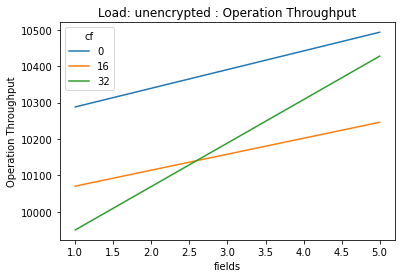

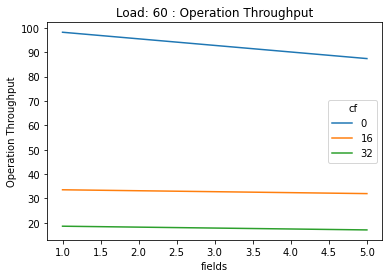

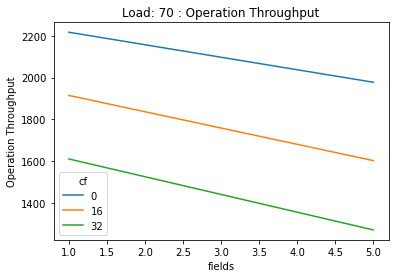

In [72]:
# Make a pivot table for operation throughput for load and graph it
def plot_patch(p):
    pd = pandas.read_csv("/tmp/summary.csv")
    pd1 = pd.query(f"Patch == '{p}'")

    #pd
    #piv = pd1.pivot(index='ContentionFactor', columns="ThreadCount", values="OperationThroughput")
    piv = pd1.pivot(index='fields', columns="cf", values="OperationThroughput")
    #piv
    piv.plot(title=f"Load: {p} : Operation Throughput", ylabel="Operation Throughput")

plot_patch("unencrypted")
plot_patch("60")
plot_patch("70")


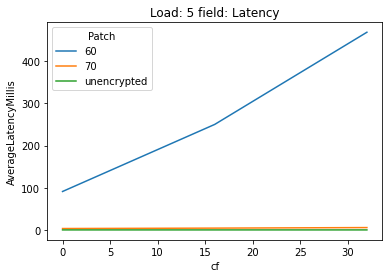

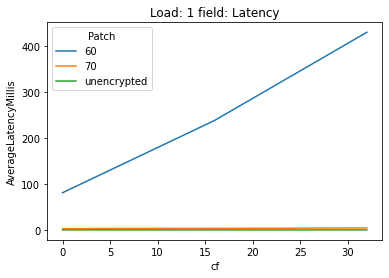

In [73]:
# Make a pivot table for operation throughput for load and graph it
#p = 5
def plot_patch_latency(p):
    pd = pandas.read_csv("/tmp/summary.csv")
    pd1 = pd.query(f"fields == {p}")
    # pd1
    #pd
    #piv = pd1.pivot(index='ContentionFactor', columns="ThreadCount", values="OperationThroughput")
    piv = pd1.pivot(index='cf', columns="Patch", values="AverageLatencyMillis")
    # piv
    piv.plot(title=f"Load: {p} field: Latency", ylabel="AverageLatencyMillis")

plot_patch_latency(5)
plot_patch_latency(1)


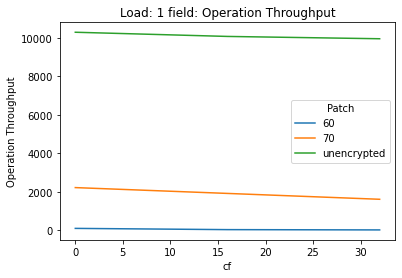

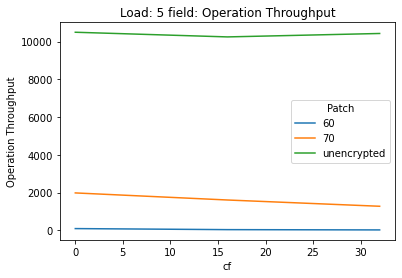

In [75]:
# Make a pivot table for operation throughput for load and graph it
#p = 5
def plot_patch_throughput(p):
    pd = pandas.read_csv("/tmp/summary.csv")
    pd1 = pd.query(f"fields == {p}")
    # pd1
    #pd
    #piv = pd1.pivot(index='ContentionFactor', columns="ThreadCount", values="OperationThroughput")
    piv = pd1.pivot(index='cf', columns="Patch", values="OperationThroughput")
    # piv
    piv.plot(title=f"Load: {p} field: Operation Throughput", ylabel="Operation Throughput")

plot_patch_throughput(1)
plot_patch_throughput(5)

0.17377942296241733 log2(x) + 2.9133083477774746
{'AverageLatency': 5549028.10927,
 'AverageLatencyMillis': 5.54902810927,
 'AverageSize': 1135.0,
 'DocumentThroughput': 1405.955628040379,
 'DocumentsTotal': 100000.0,
 'DurationTotal': 71126000000.0,
 'ErrorRate': 0.0,
 'ErrorsTotal': 0.0,
 'Latency50thPercentile': 5305124.5,
 'Latency50thPercentileMillis': 5.3051245,
 'Latency80thPercentile': 6408243.800000001,
 'Latency80thPercentileMillis': 6.408243800000001,
 'Latency90thPercentile': 7077577.8,
 'Latency90thPercentileMillis': 7.0775778,
 'Latency95thPercentile': 7772444.8999999985,
 'Latency95thPercentileMillis': 7.772444899999998,
 'Latency99thPercentile': 10918452.649999995,
 'Latency99thPercentileMillis': 10.918452649999995,
 'LatencyMax': 279556862.0,
 'LatencyMin': 2255715.0,
 'OperationThroughput': 1405.955628040379,
 'OperationsTotal': 100000.0,
 'OverheadTotal': 13452535332.0,
 'SizeThroughput': 1595759.6378258301,
 'SizeTotal': 113500000.0,
 'WorkersMax': 8,
 'WorkersMin':

/usr/lib64/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


0.3447525391332202 log2(x) + 2.2479862715764853
{'AverageLatency': 7476862.42232,
 'AverageLatencyMillis': 7.476862422320001,
 'AverageSize': 1135.0,
 'DocumentThroughput': 1044.440973883137,
 'DocumentsTotal': 100000.0,
 'DurationTotal': 95744999000.0,
 'ErrorRate': 0.0,
 'ErrorsTotal': 0.0,
 'Latency50thPercentile': 6972869.0,
 'Latency50thPercentileMillis': 6.972869,
 'Latency80thPercentile': 8574322.200000001,
 'Latency80thPercentileMillis': 8.574322200000001,
 'Latency90thPercentile': 9744625.733333332,
 'Latency90thPercentileMillis': 9.744625733333333,
 'Latency95thPercentile': 11331538.59999999,
 'Latency95thPercentileMillis': 11.331538599999991,
 'Latency99thPercentile': 17856220.50333333,
 'Latency99thPercentileMillis': 17.85622050333333,
 'LatencyMax': 243838517.0,
 'LatencyMin': 3549655.0,
 'OperationThroughput': 1044.440973883137,
 'OperationsTotal': 100000.0,
 'OverheadTotal': 14615292328.0,
 'SizeThroughput': 1185440.5053573607,
 'SizeTotal': 113500000.0,
 'WorkersMax': 8

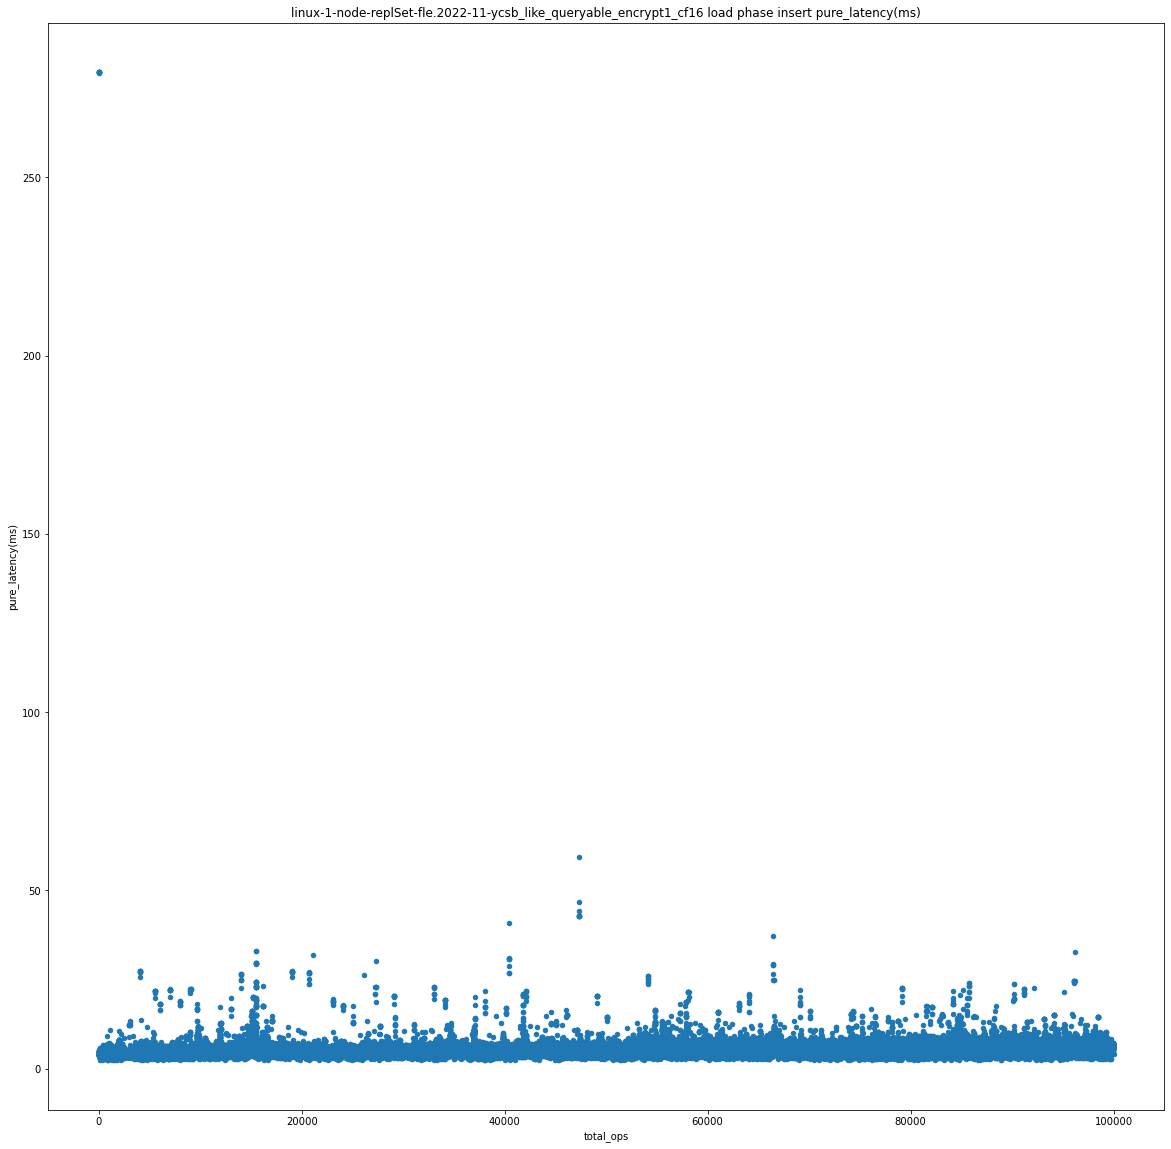

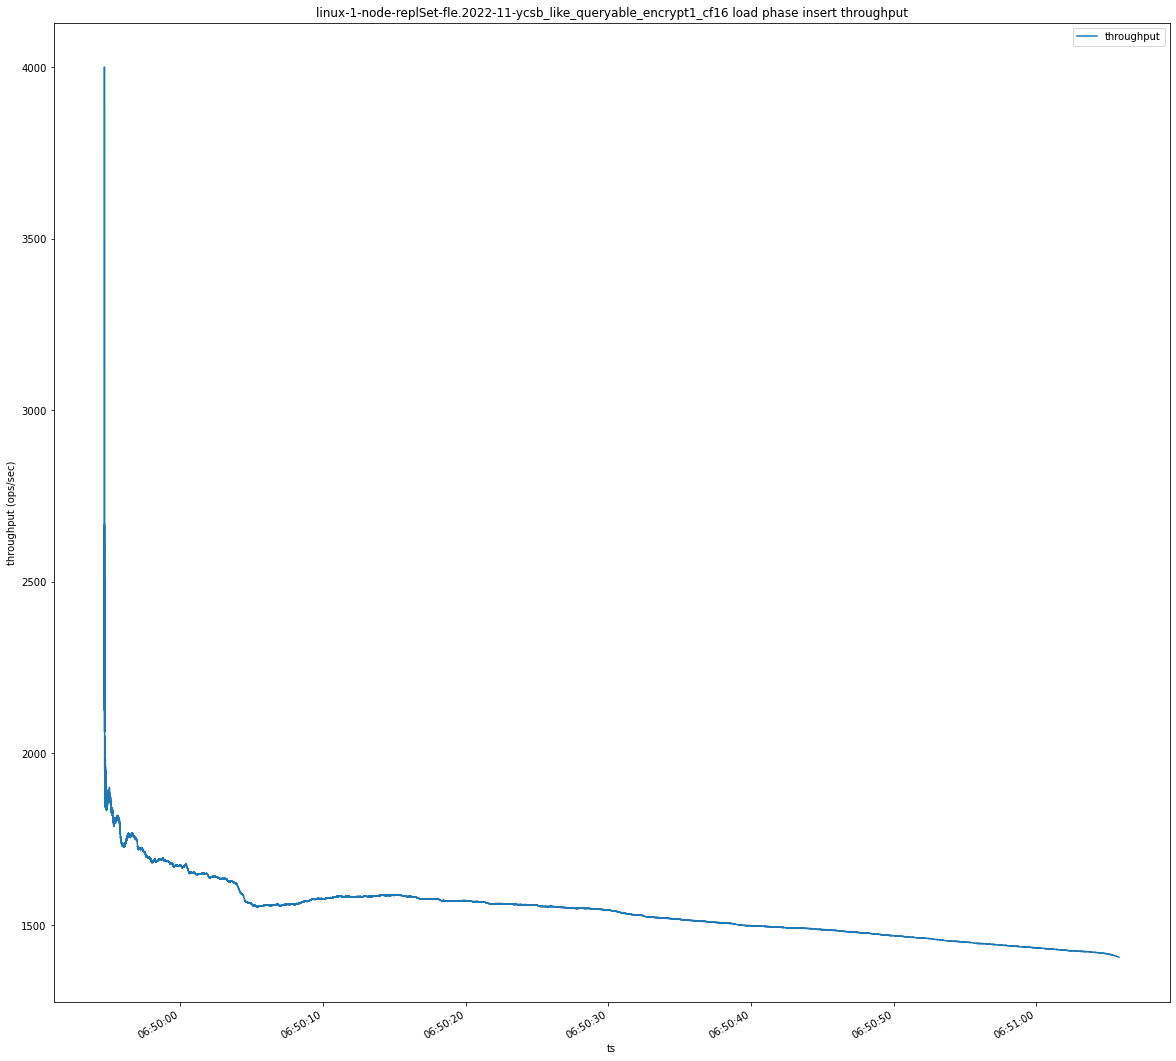

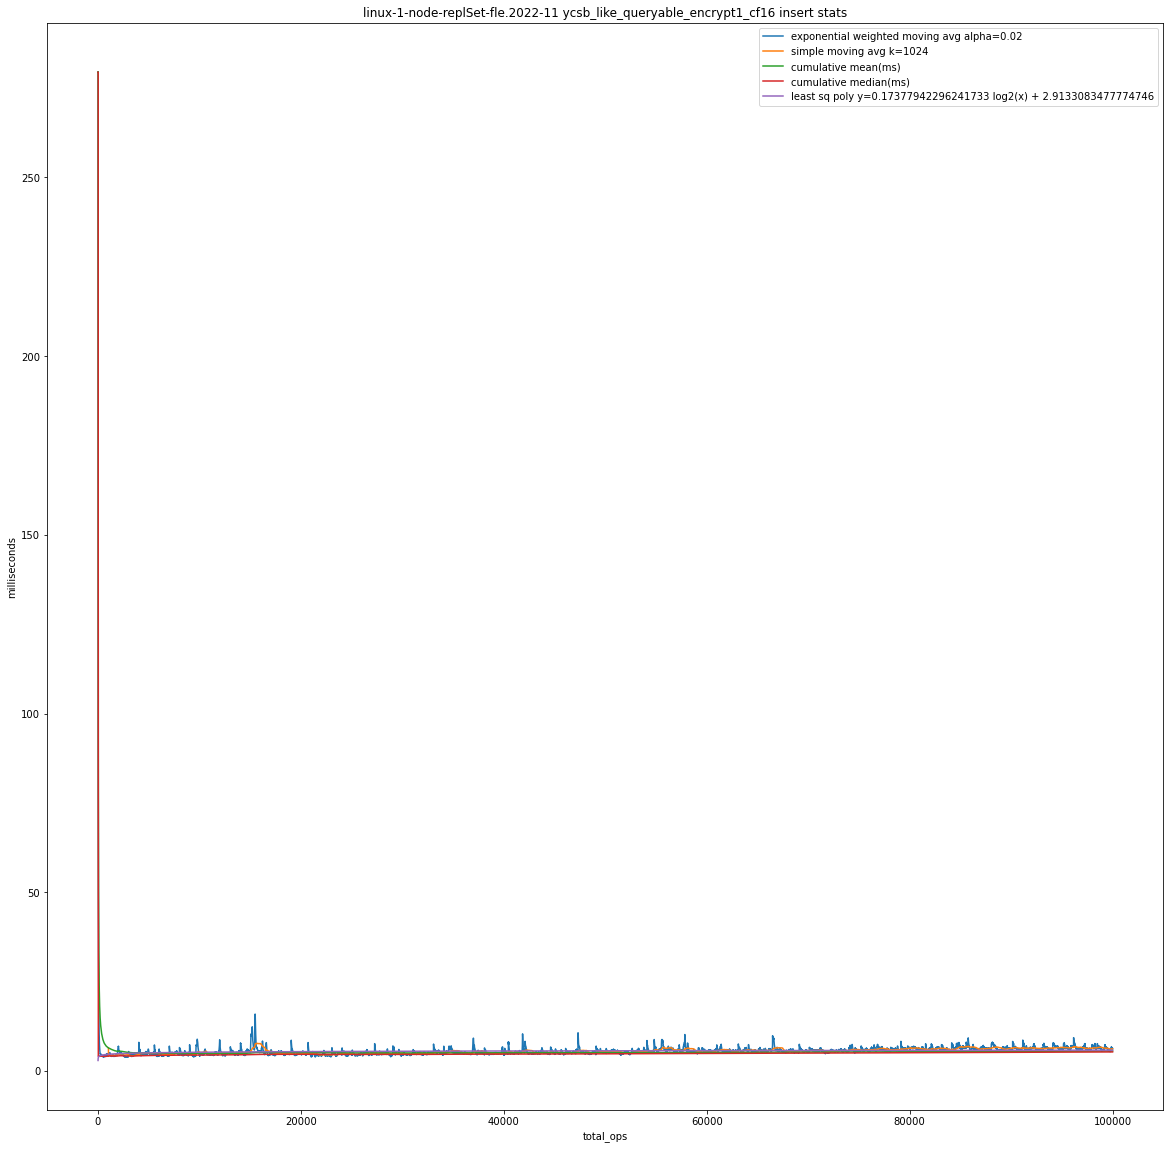

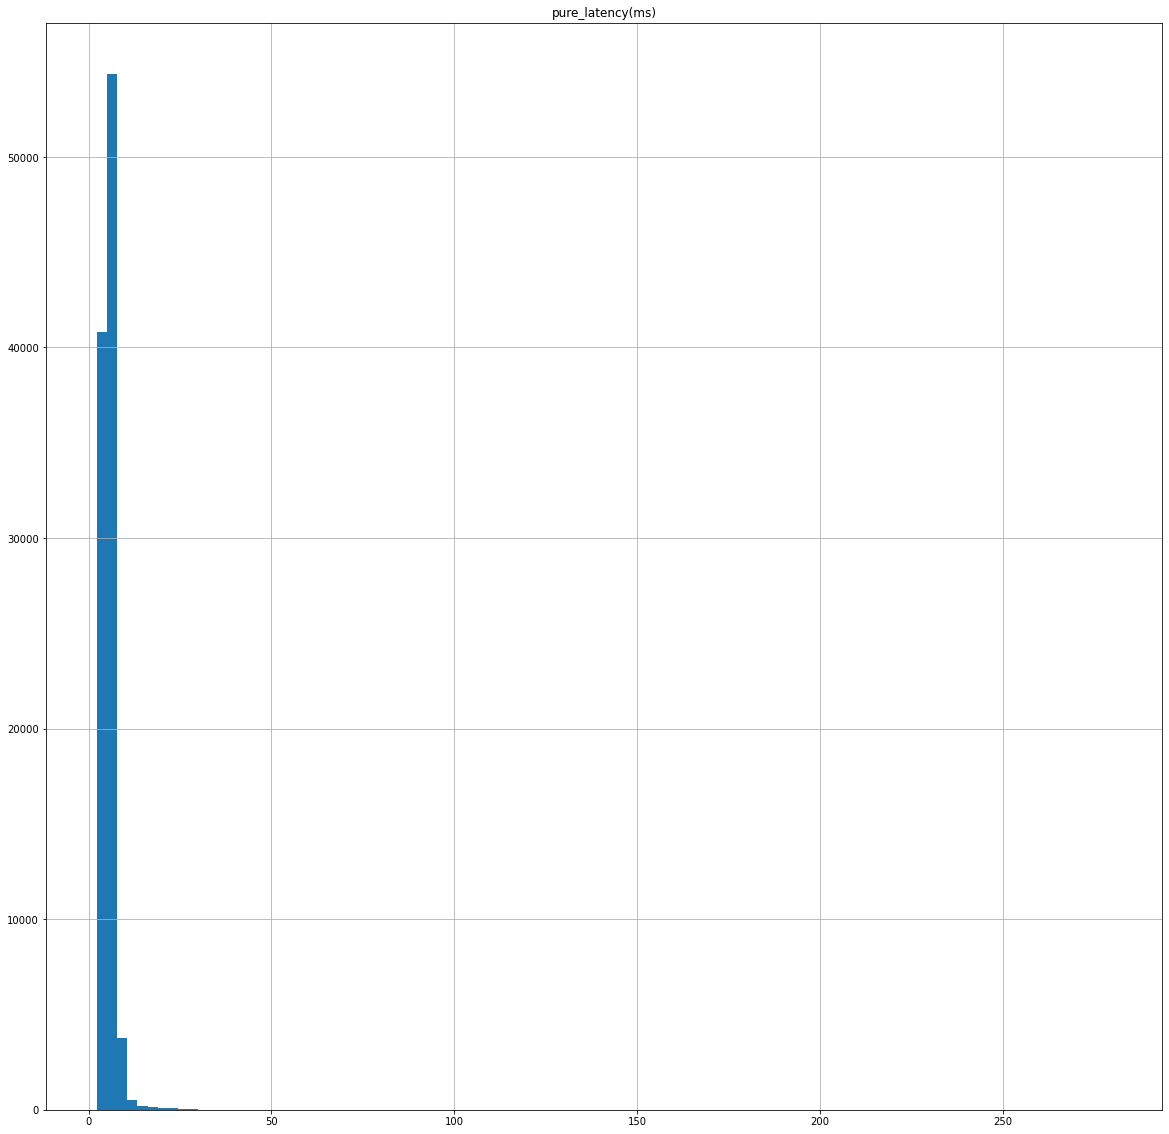

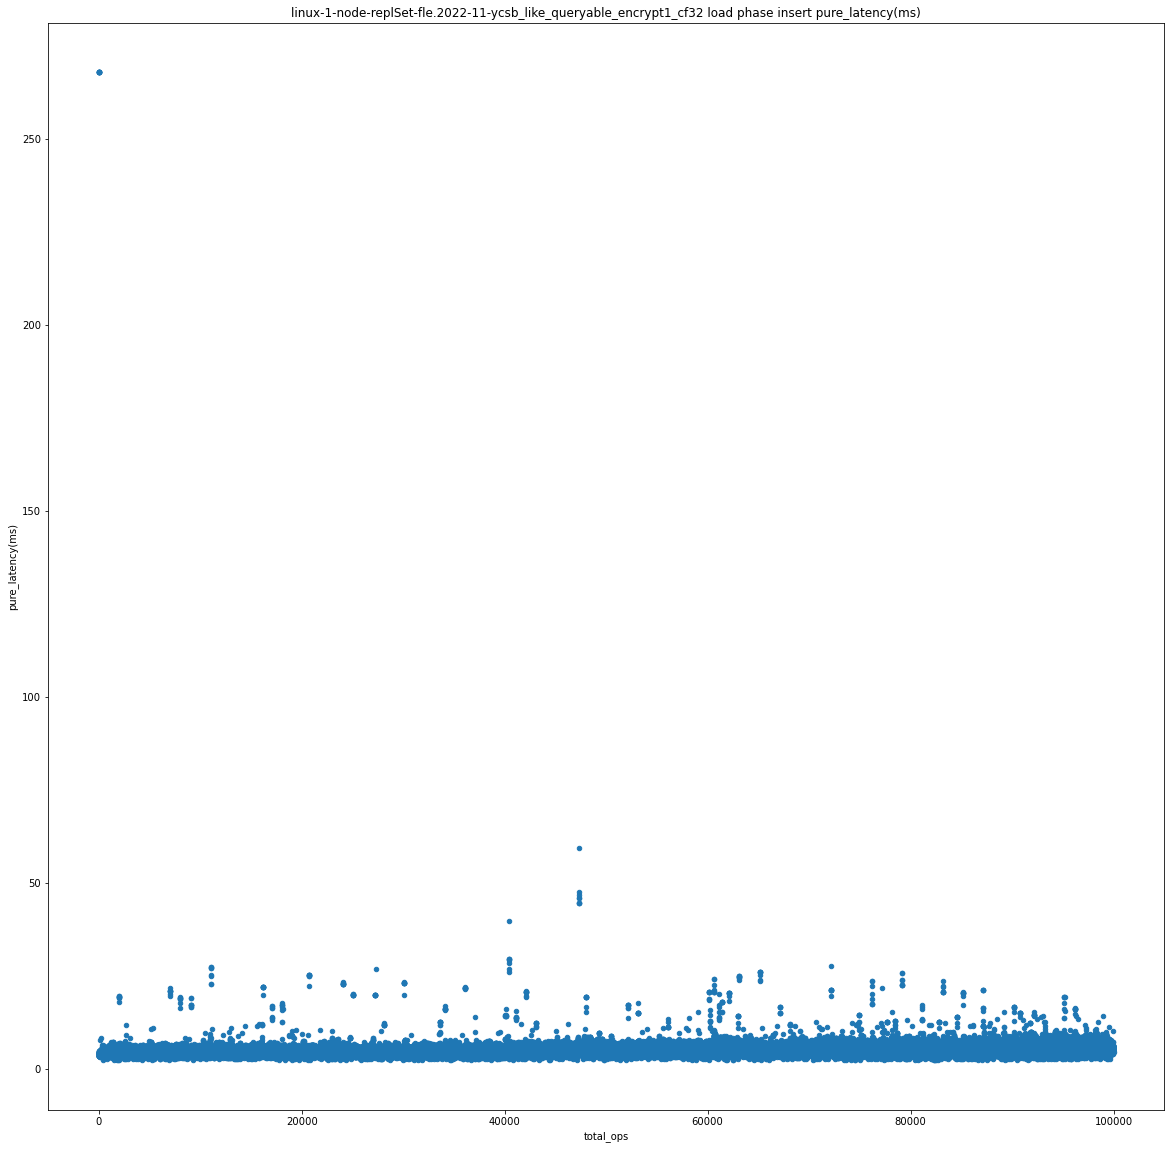

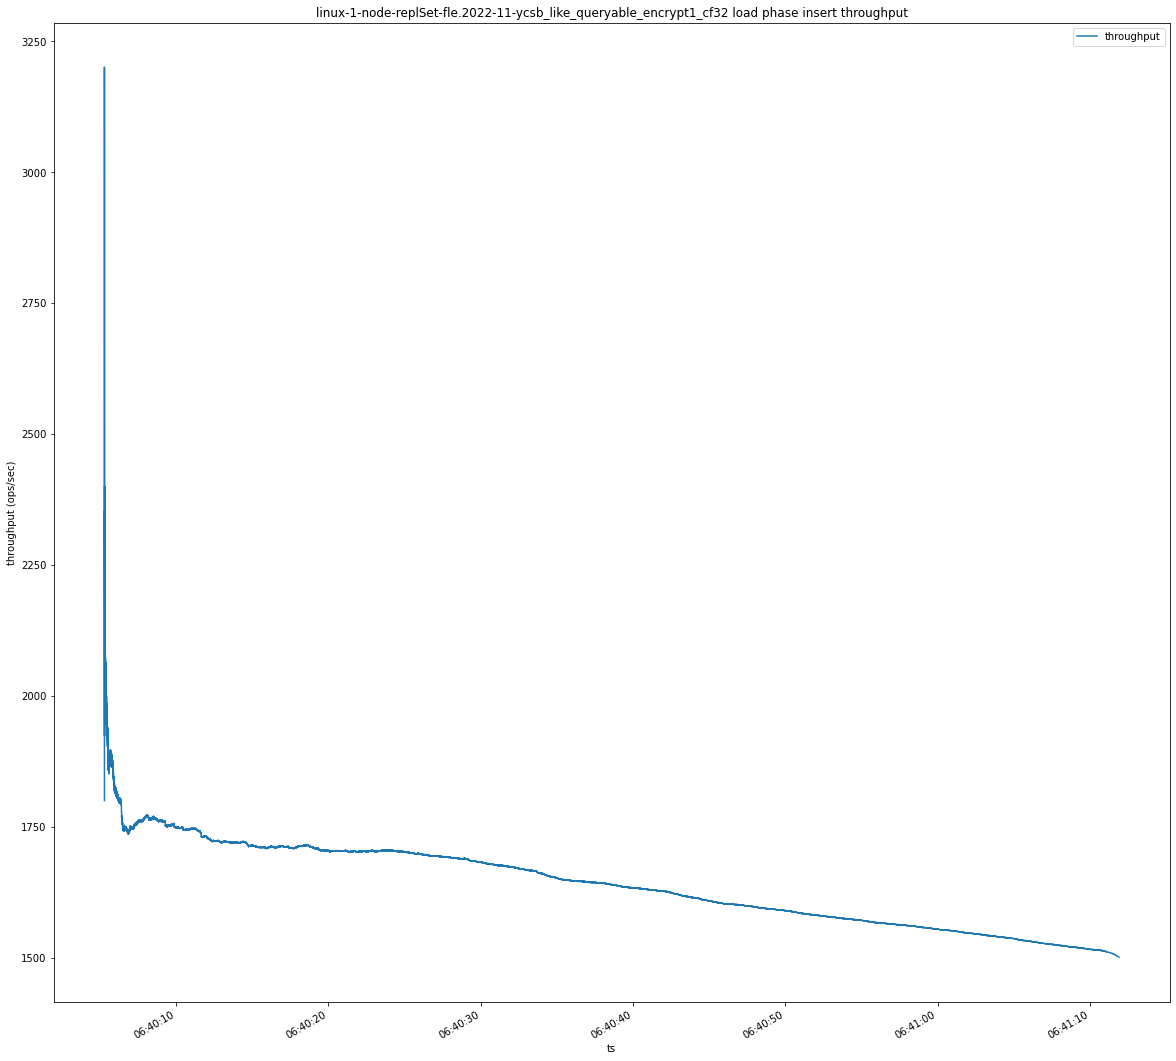

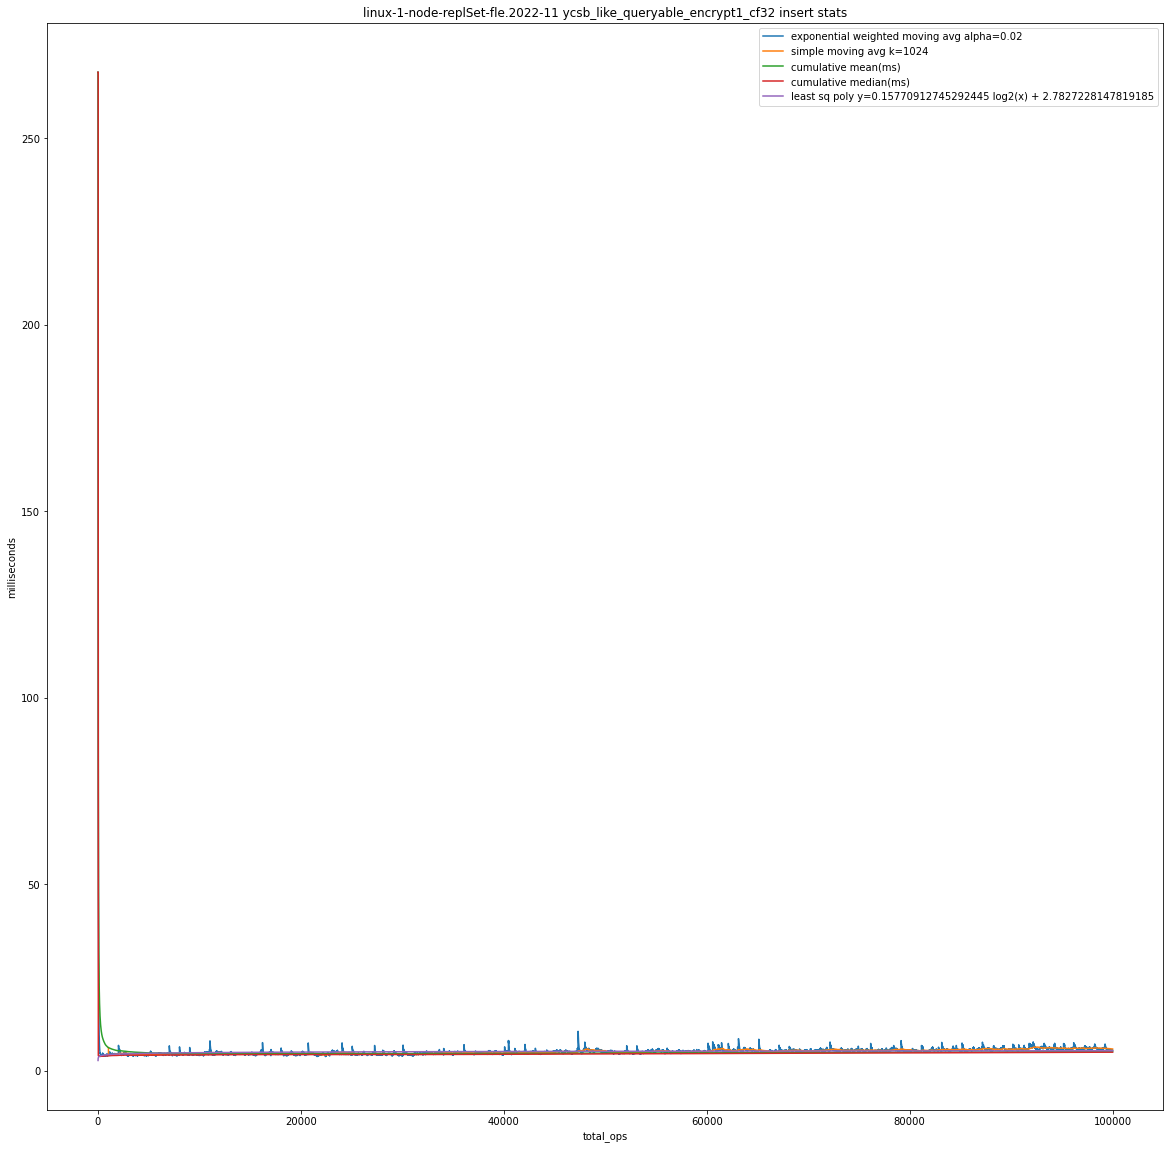

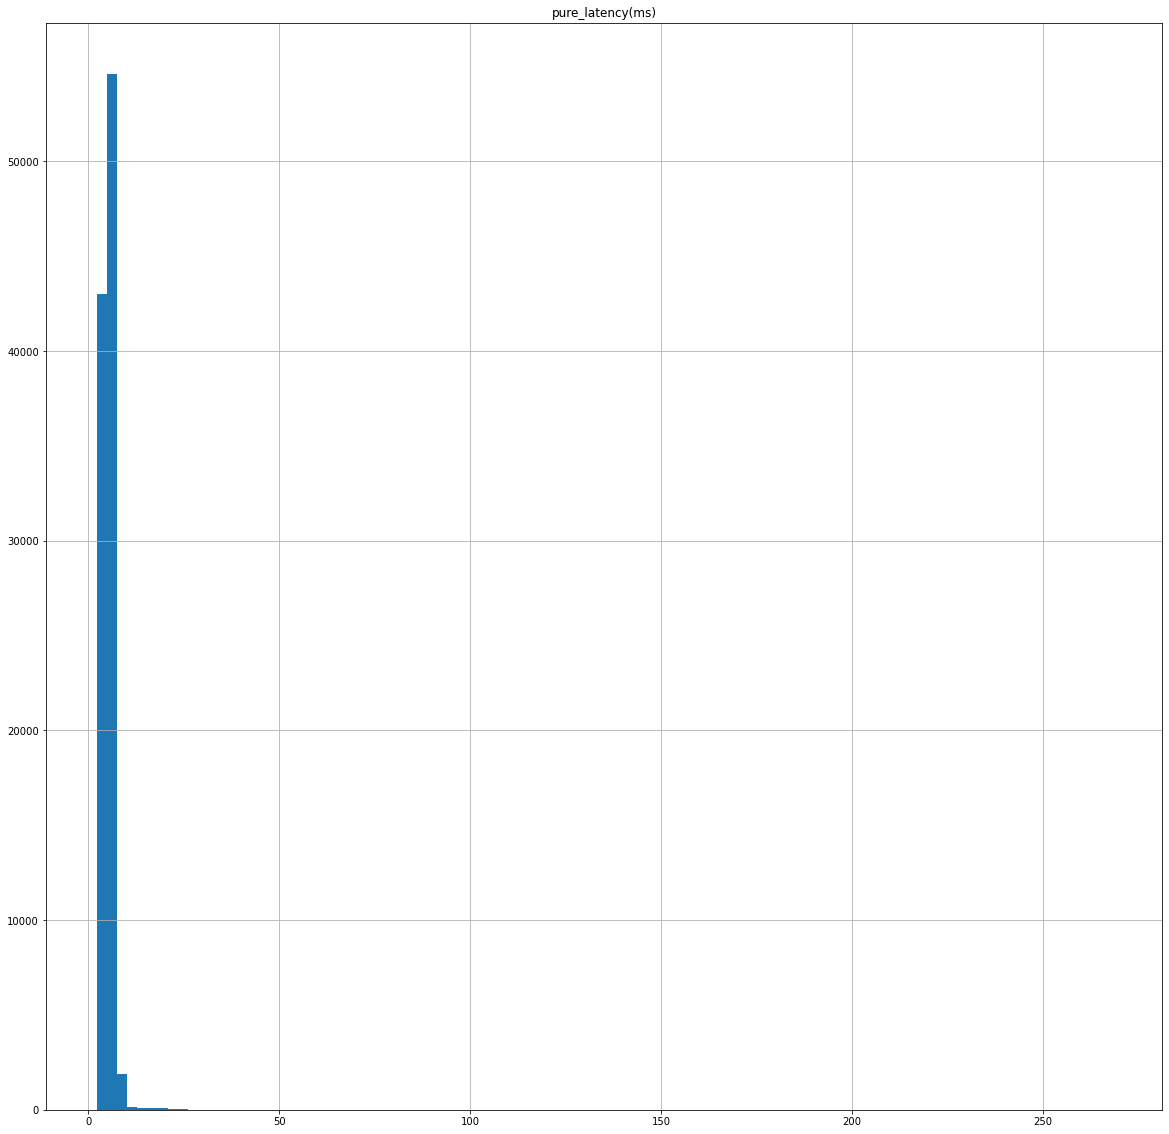

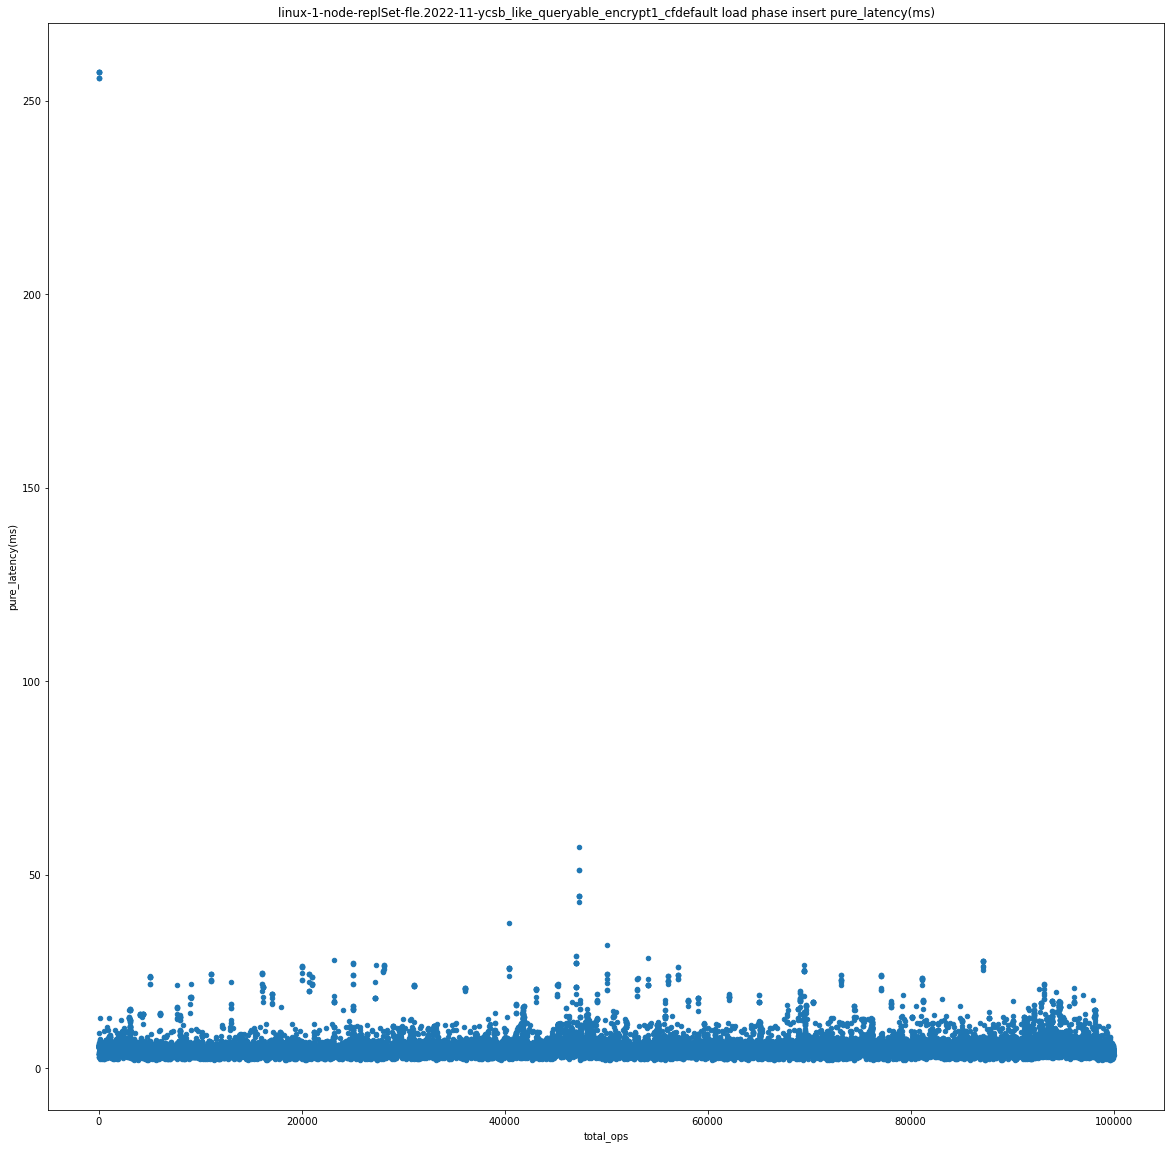

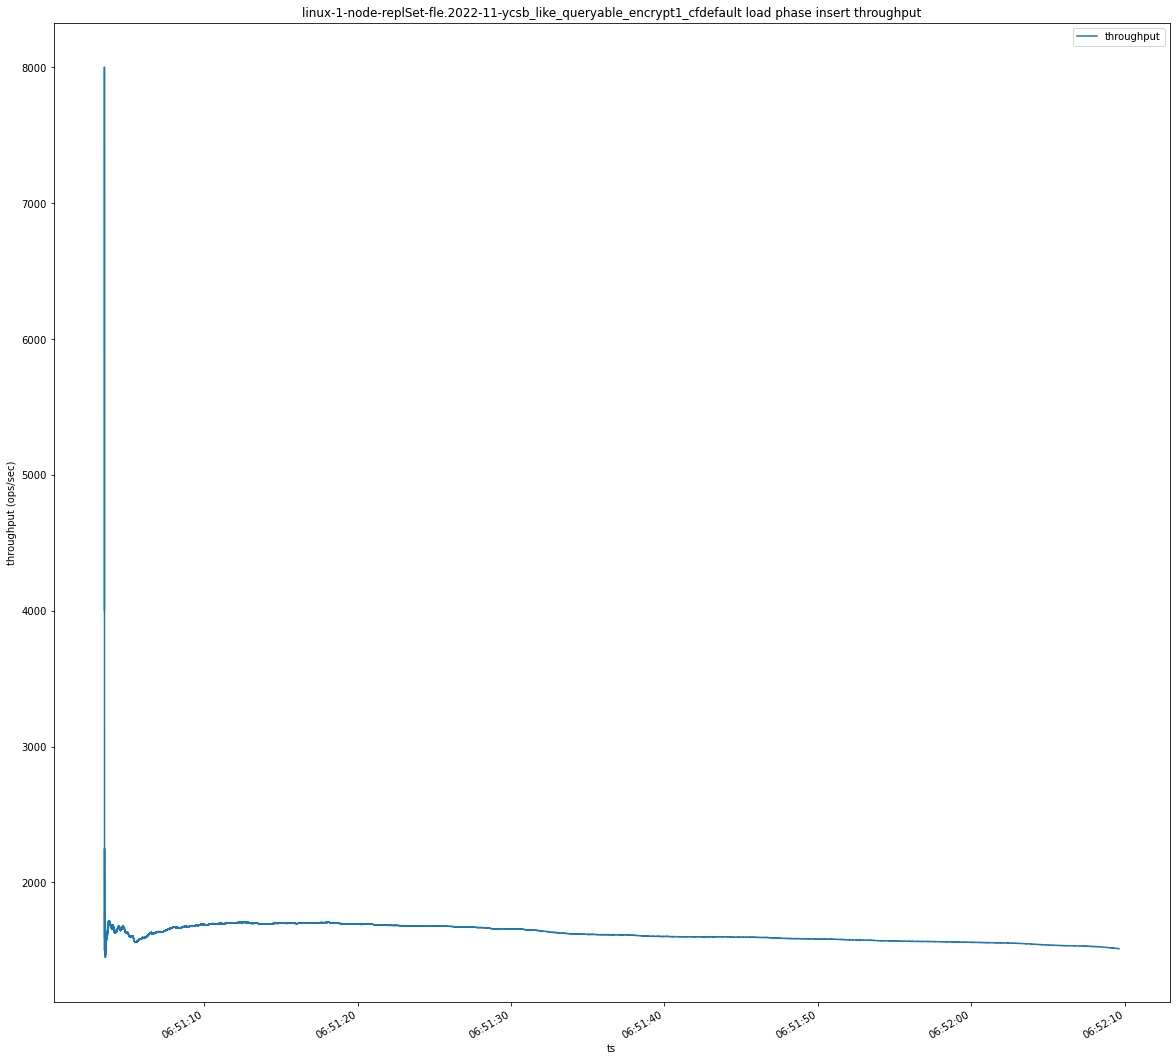

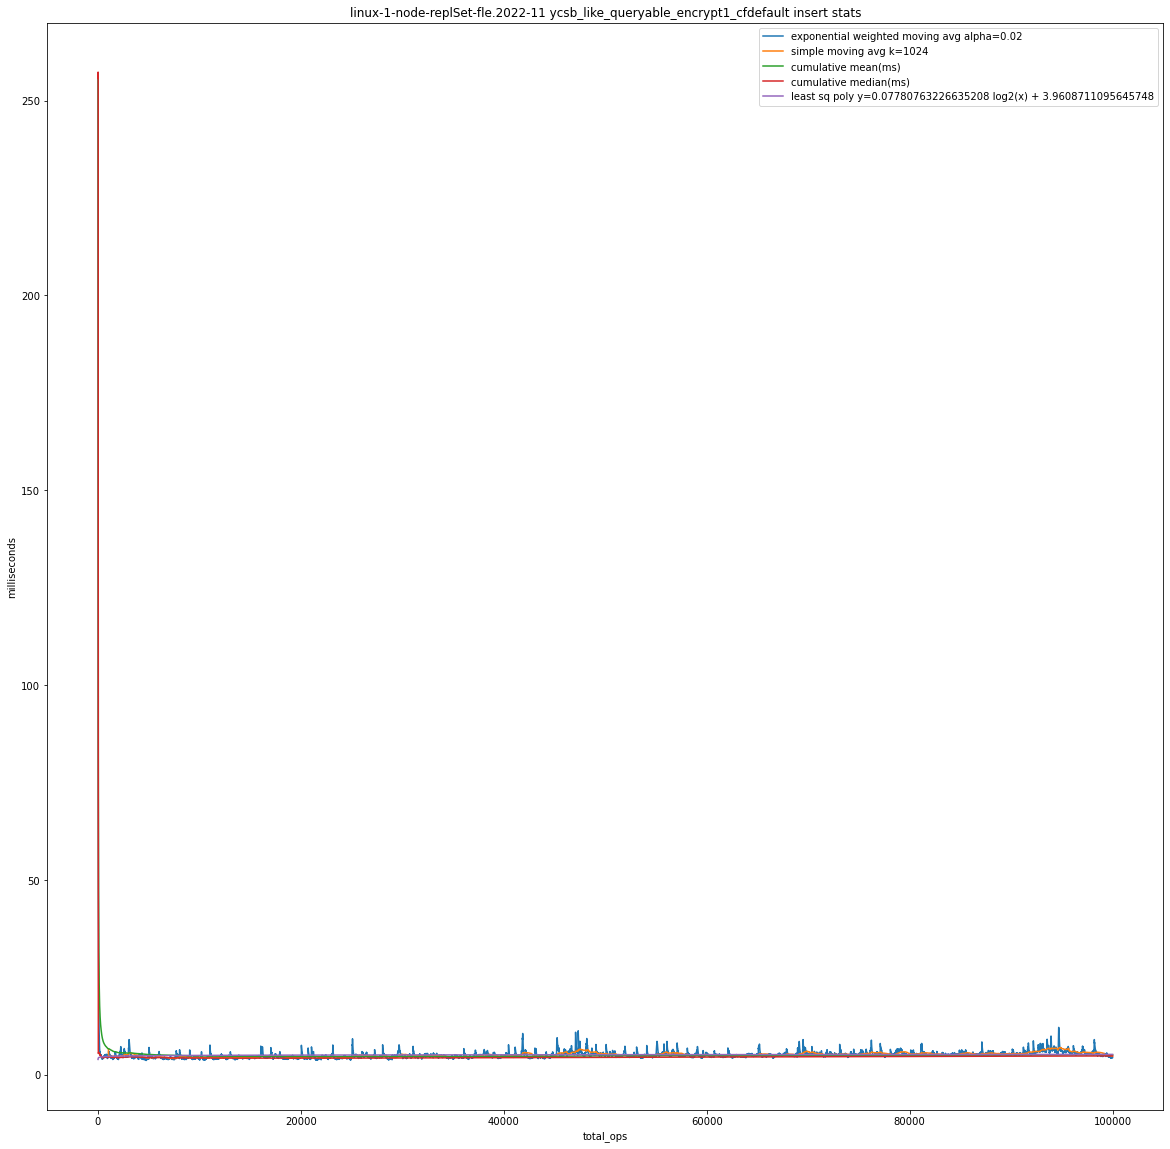

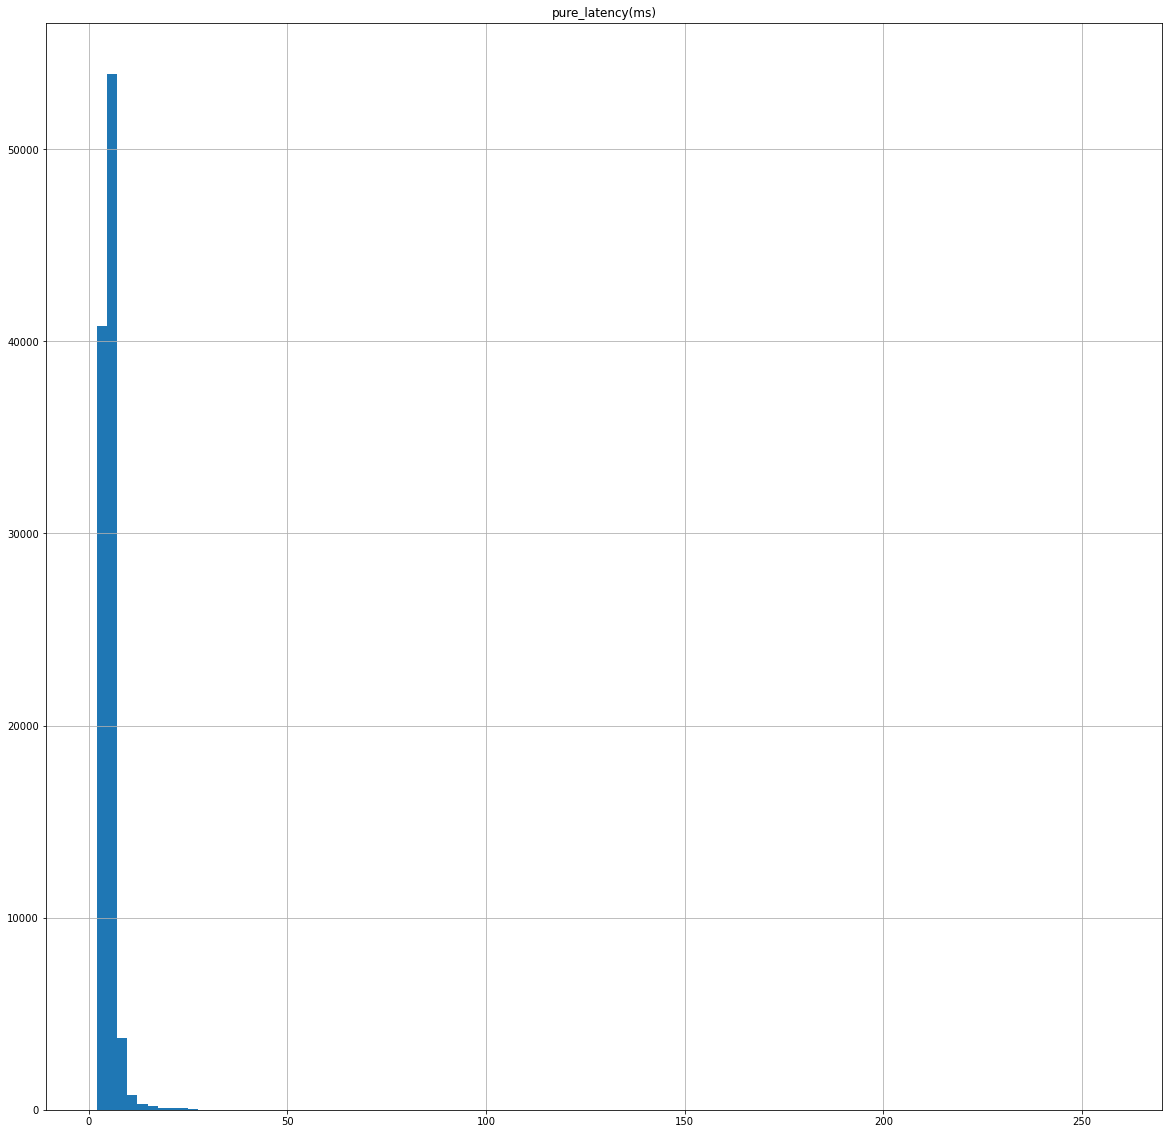

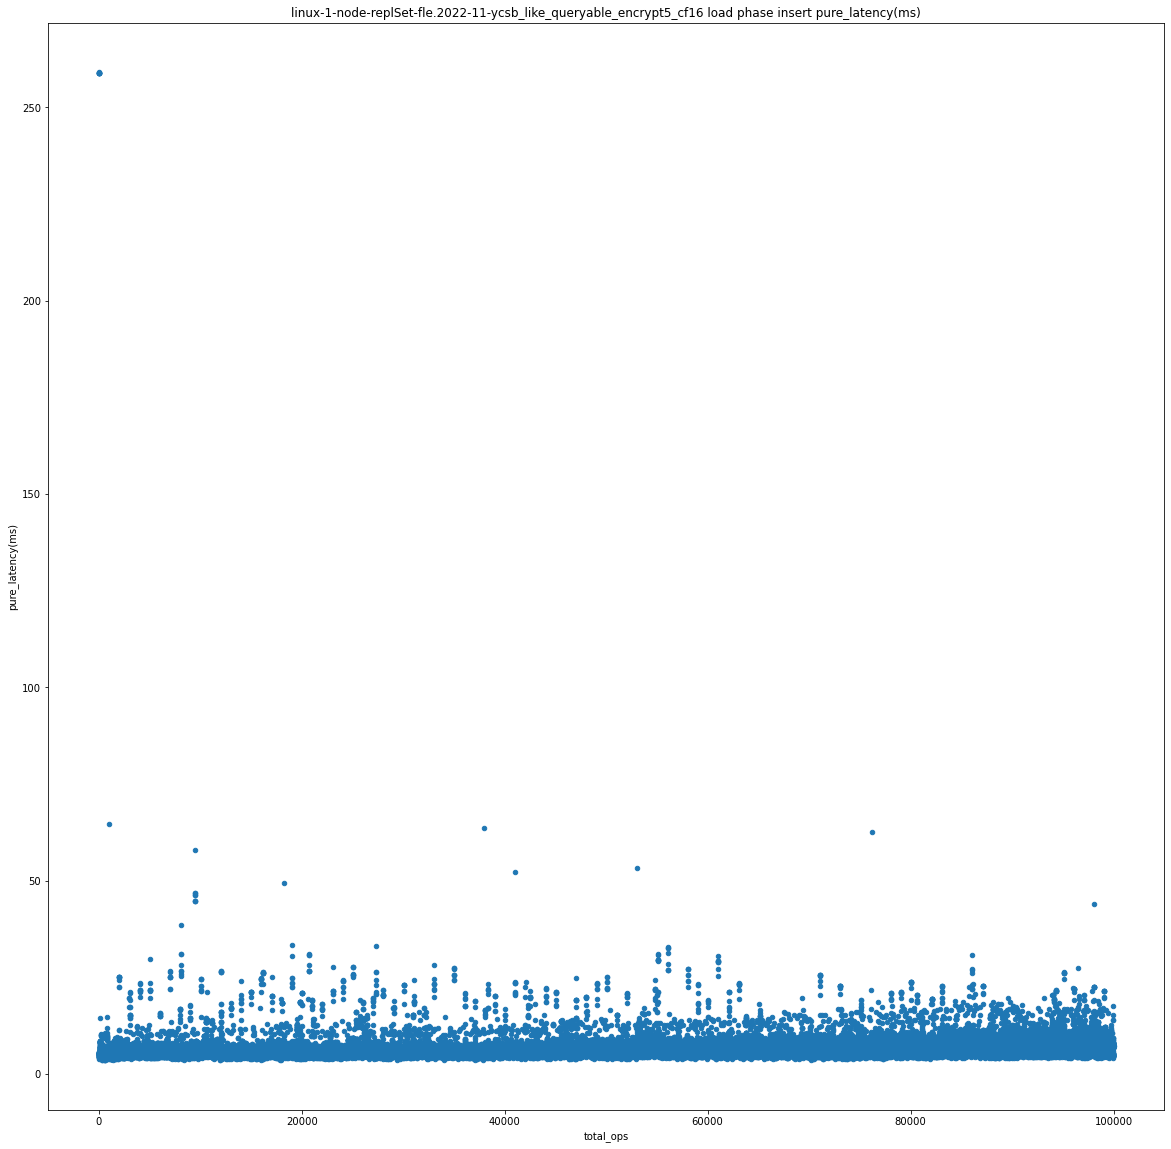

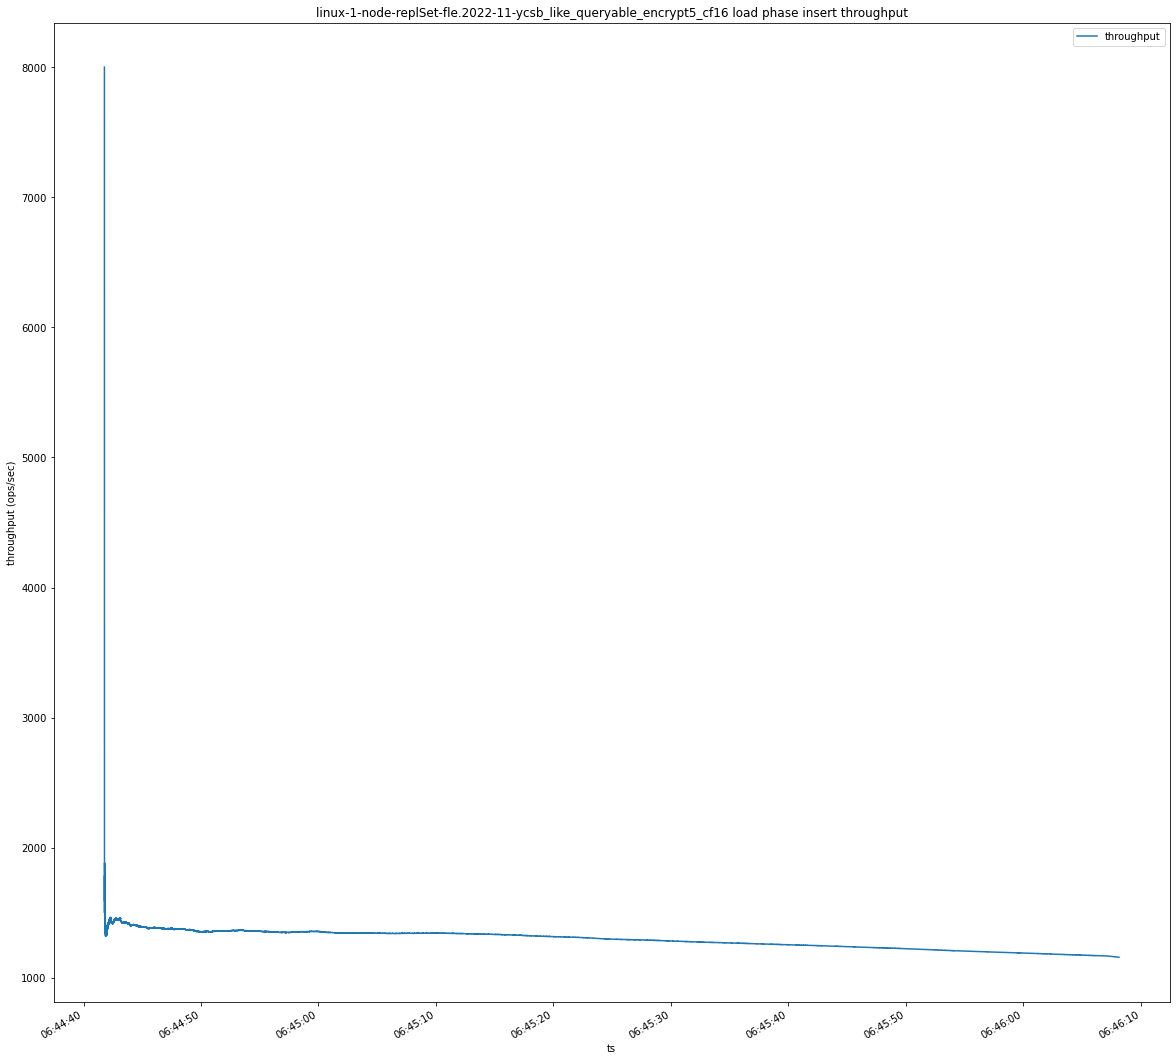

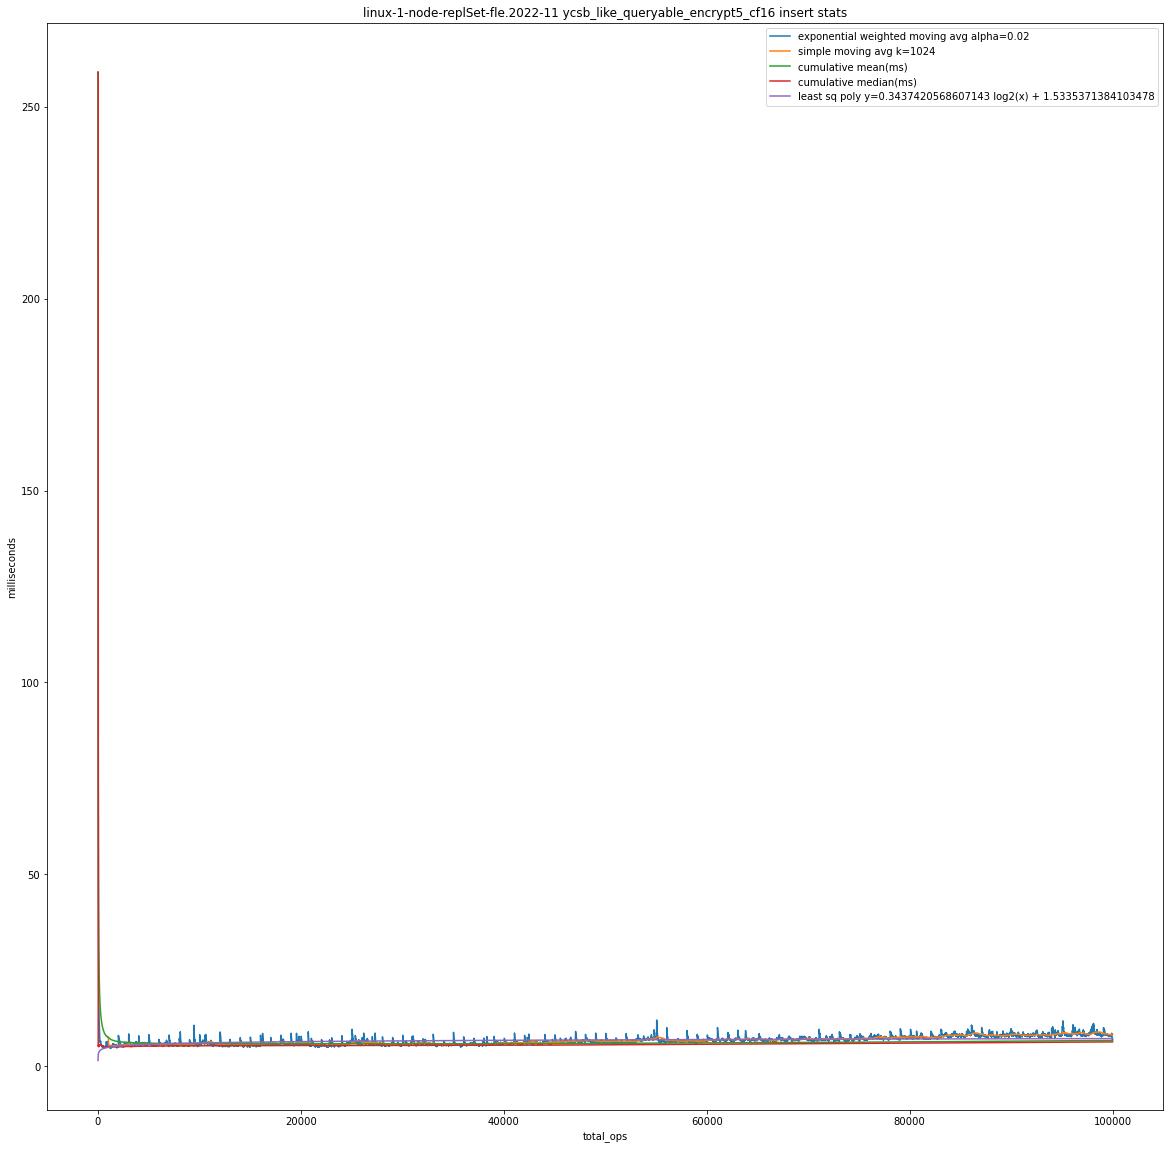

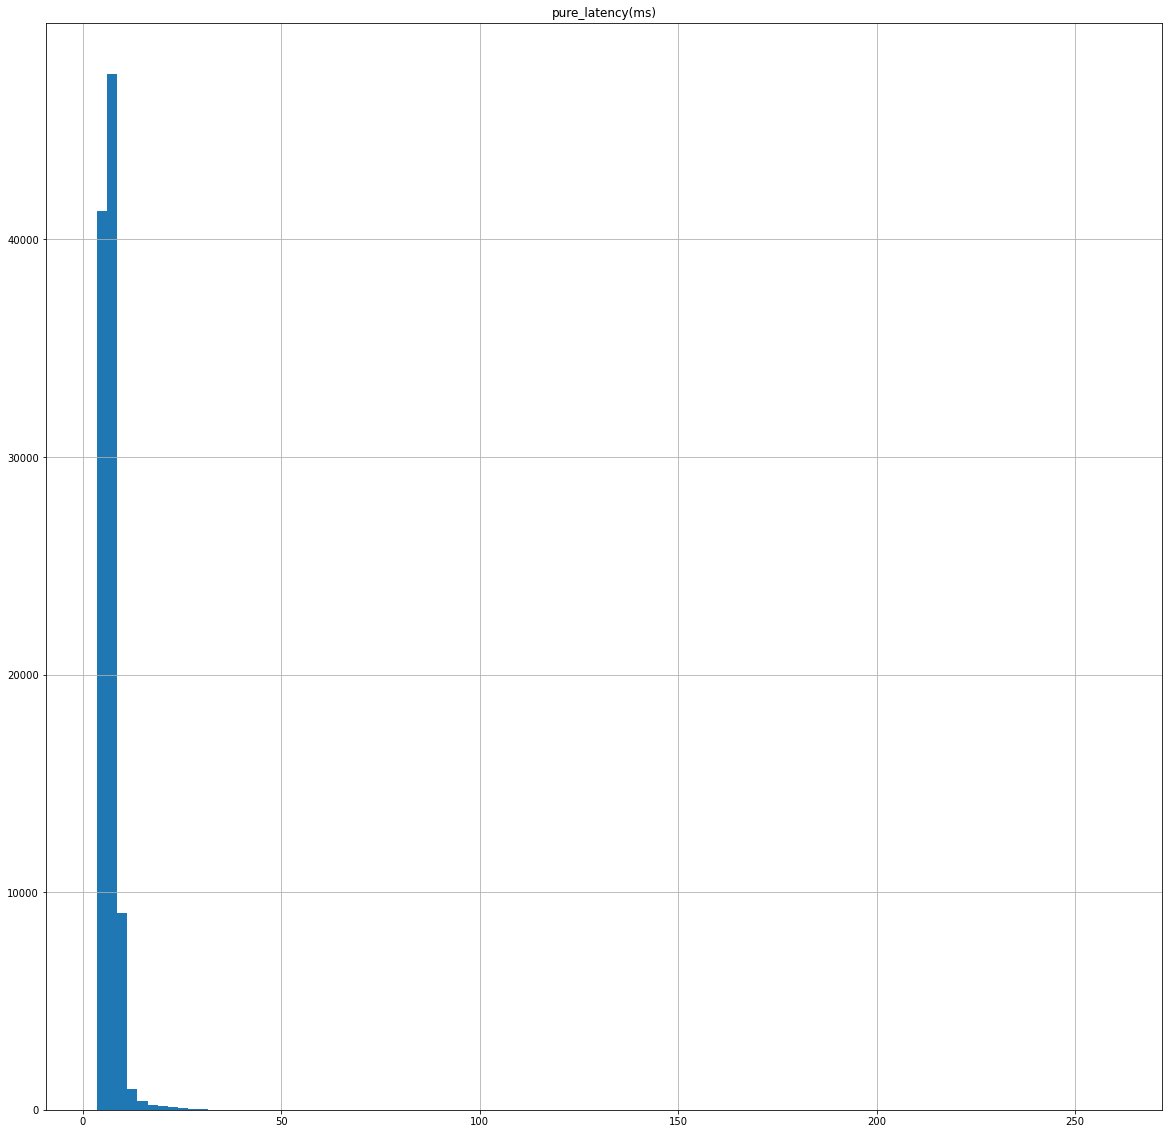

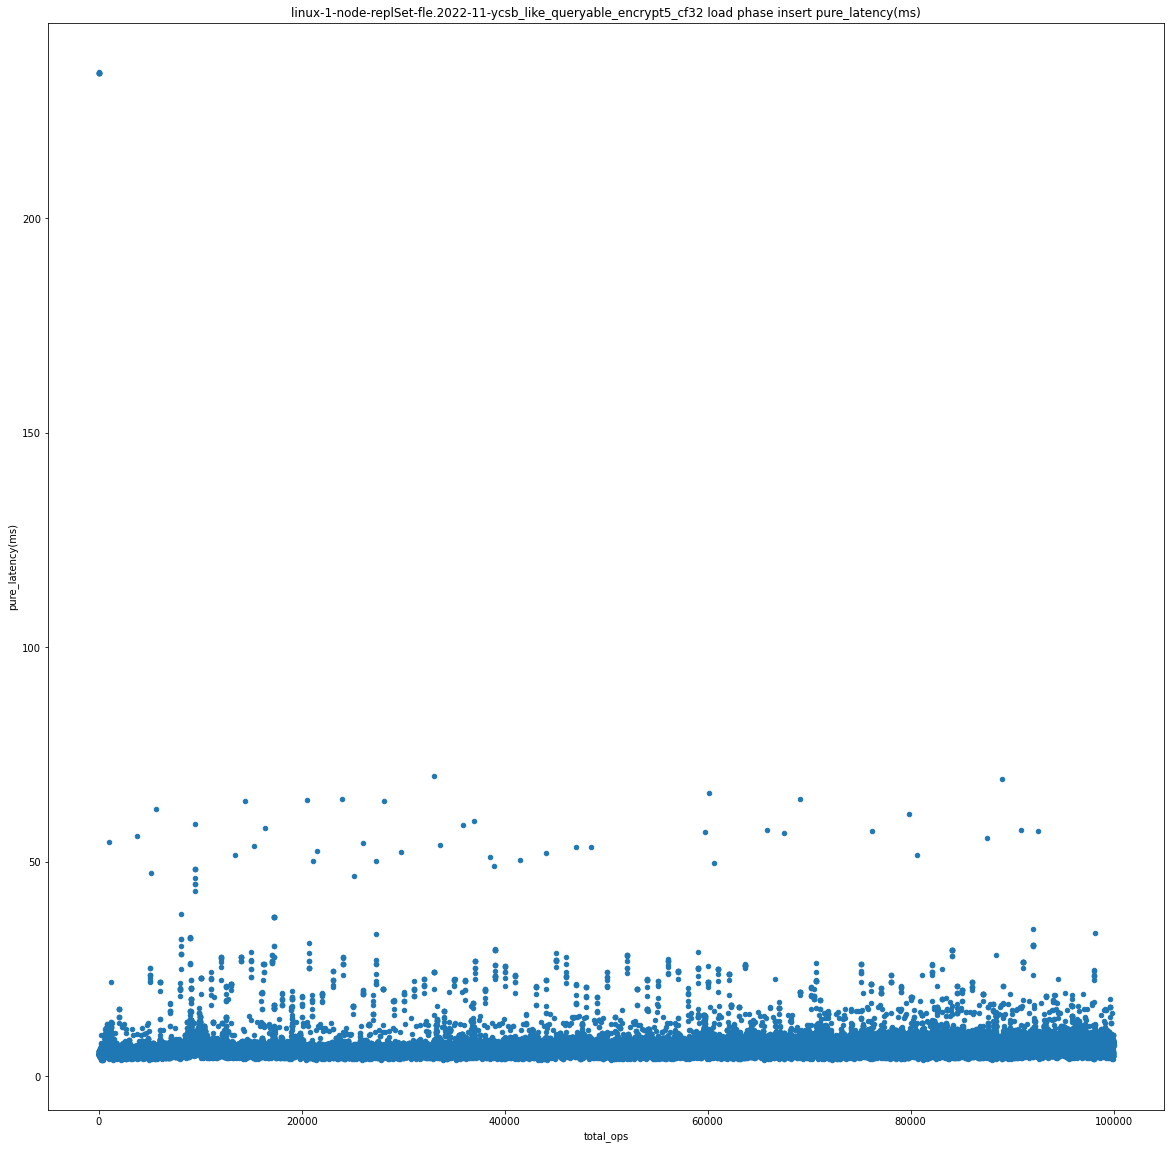

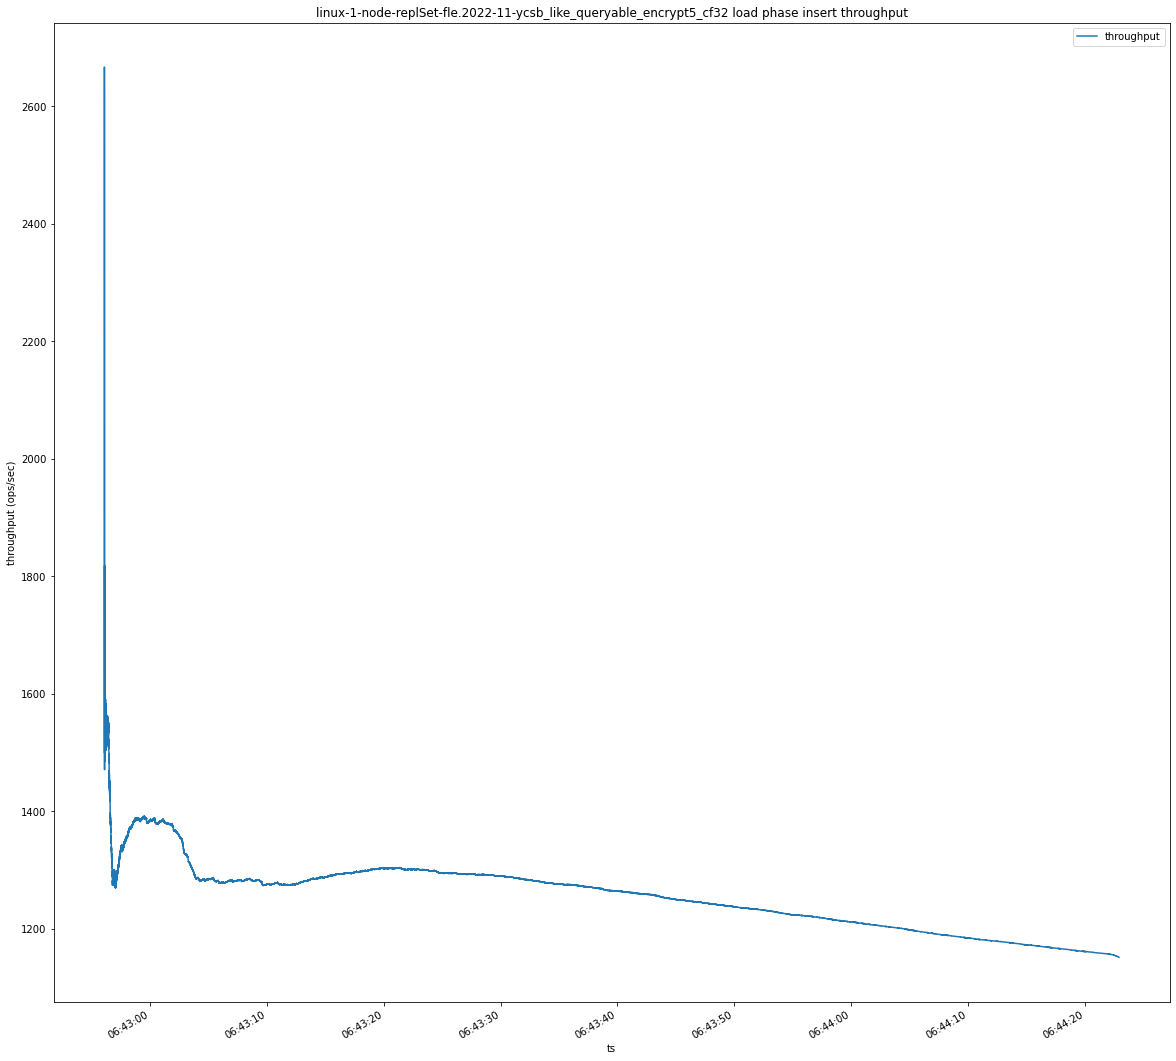

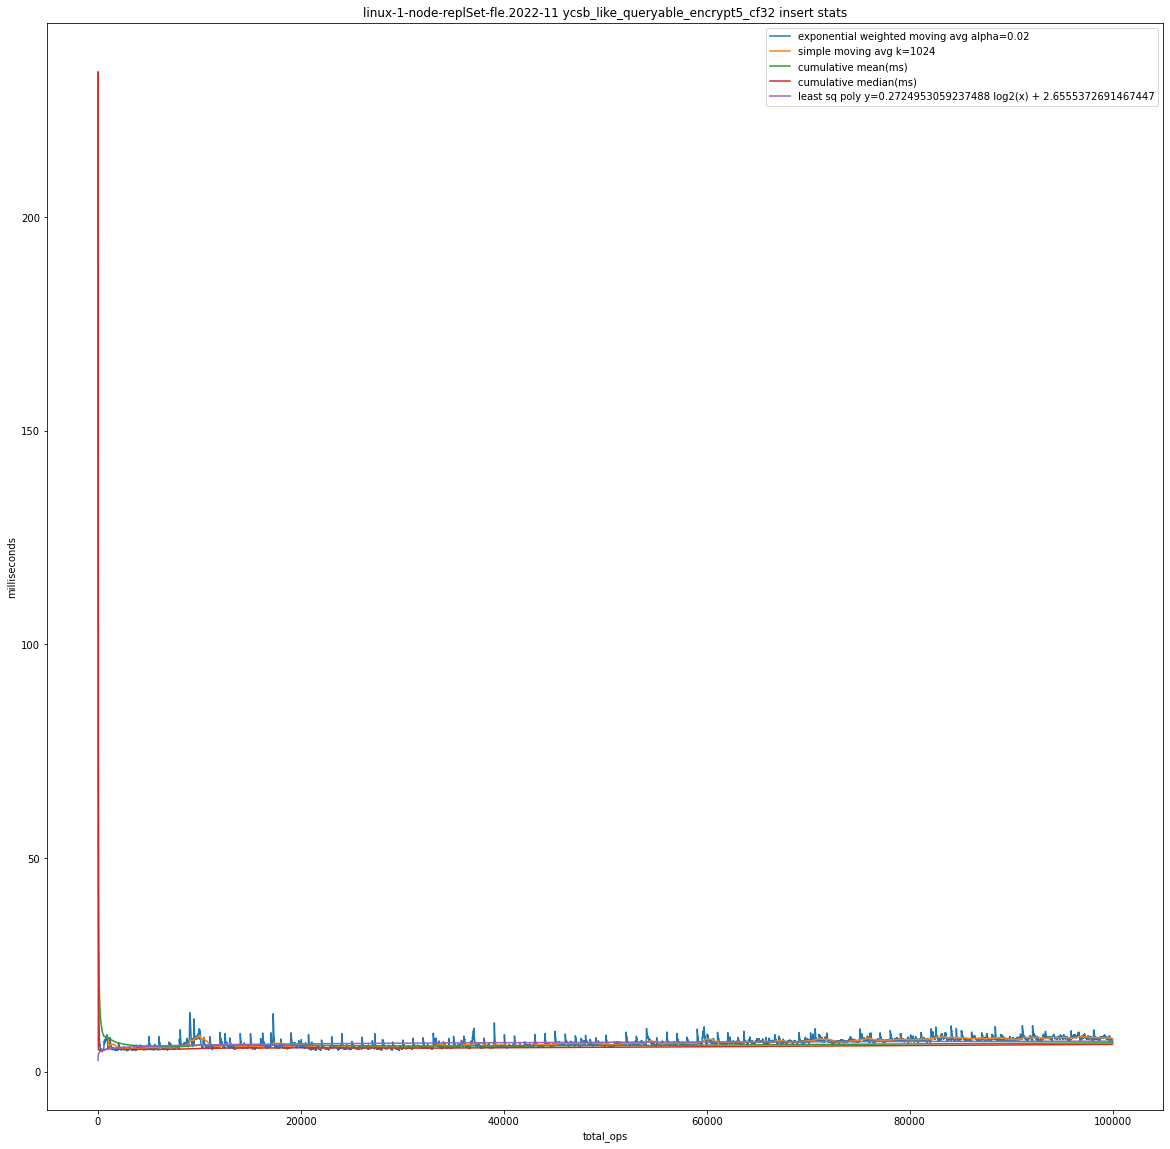

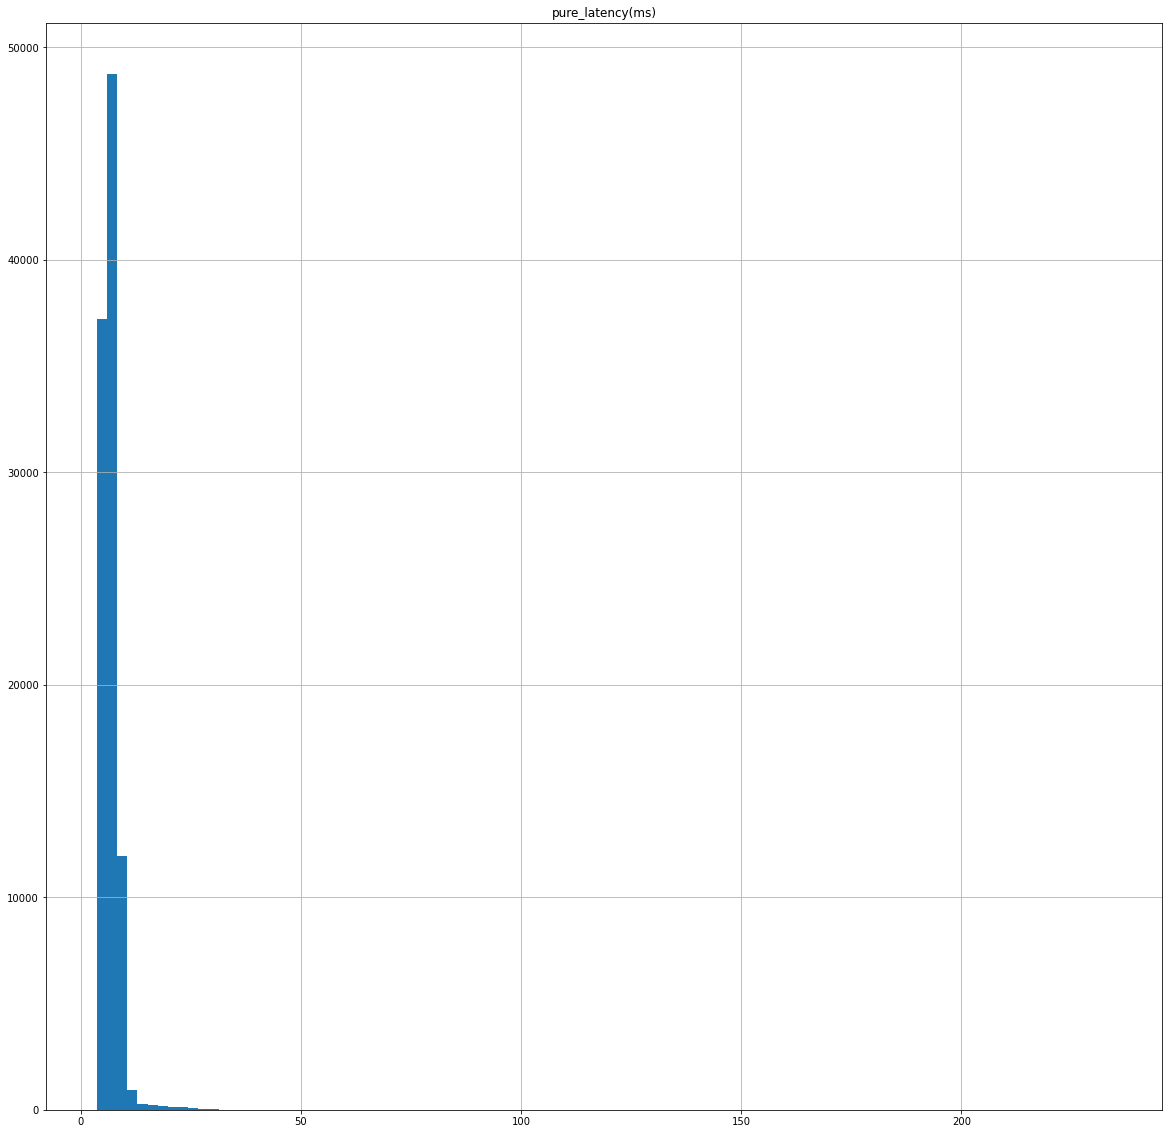

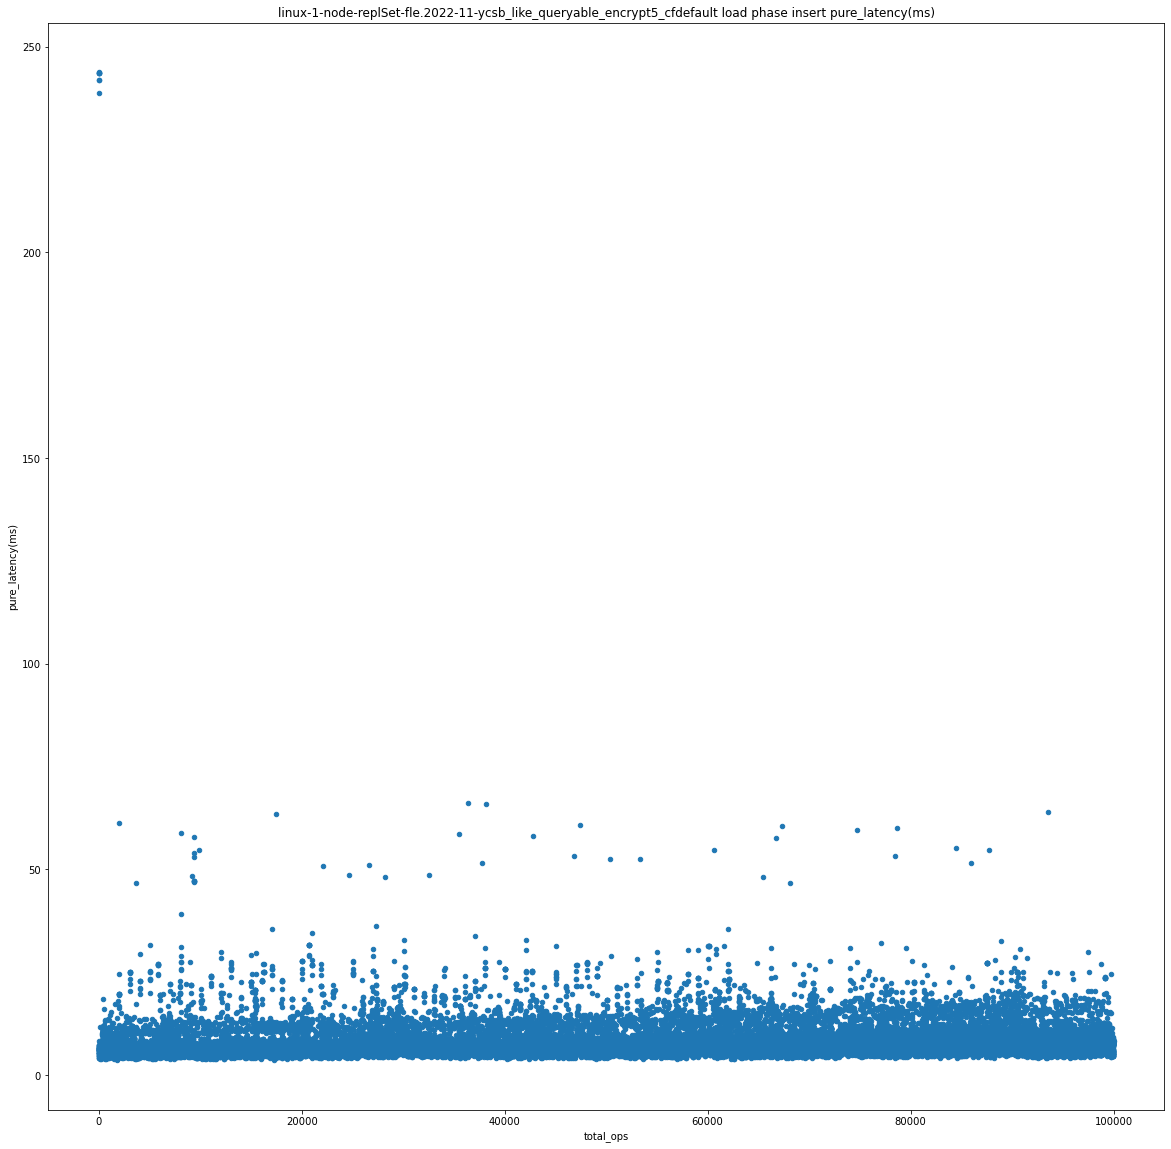

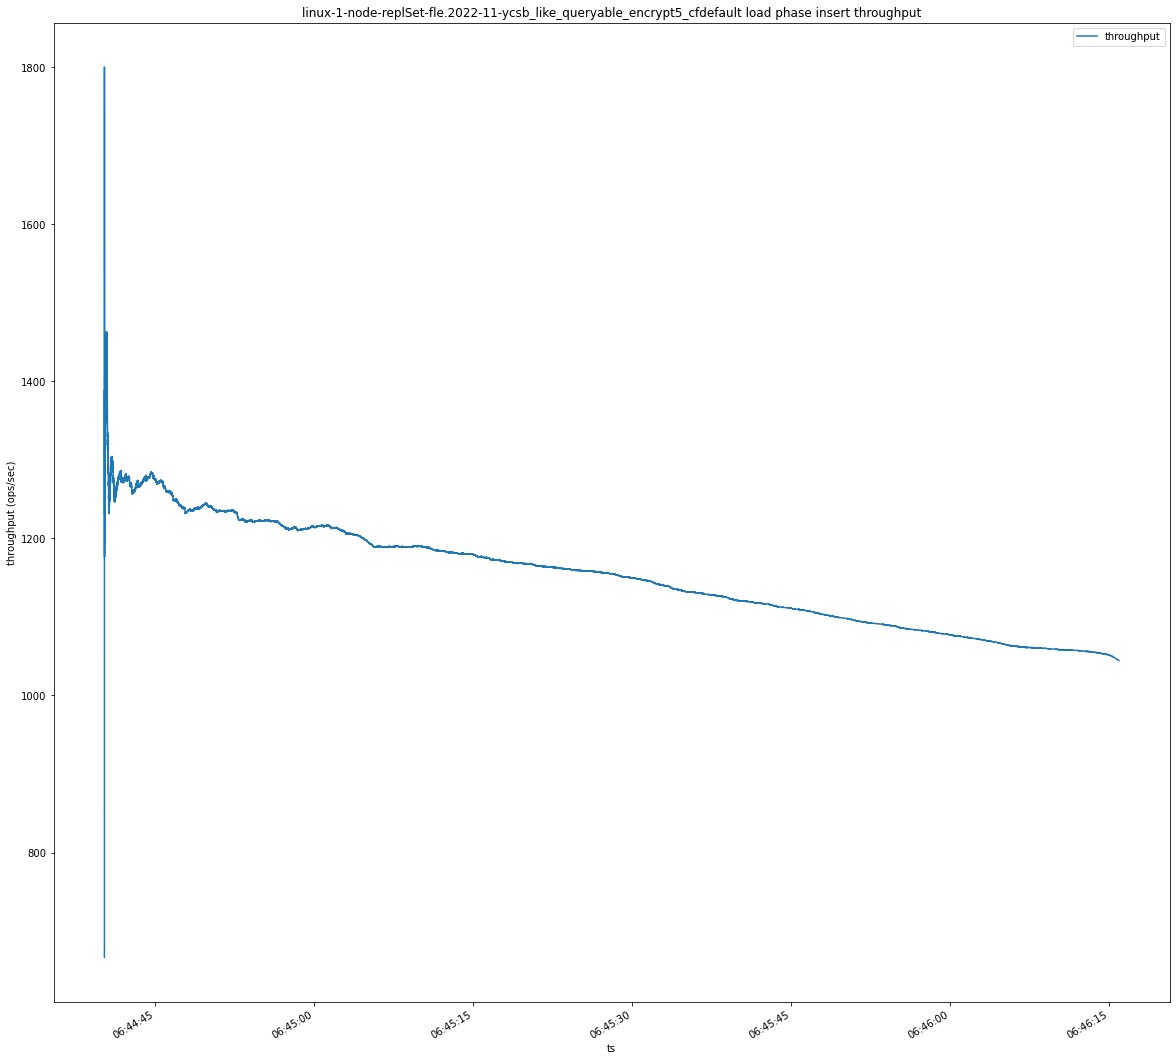

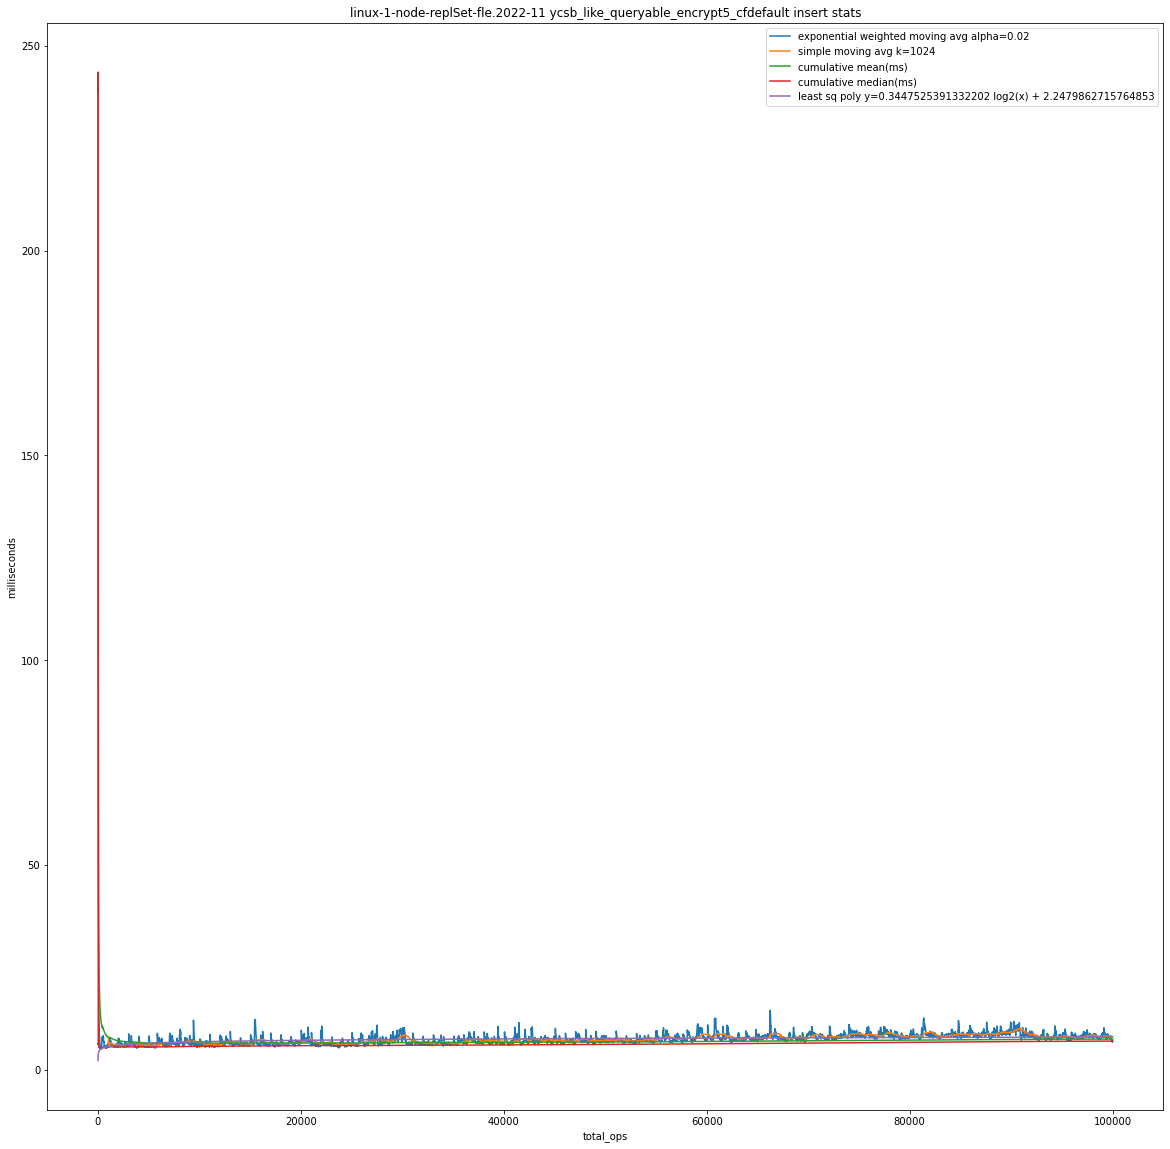

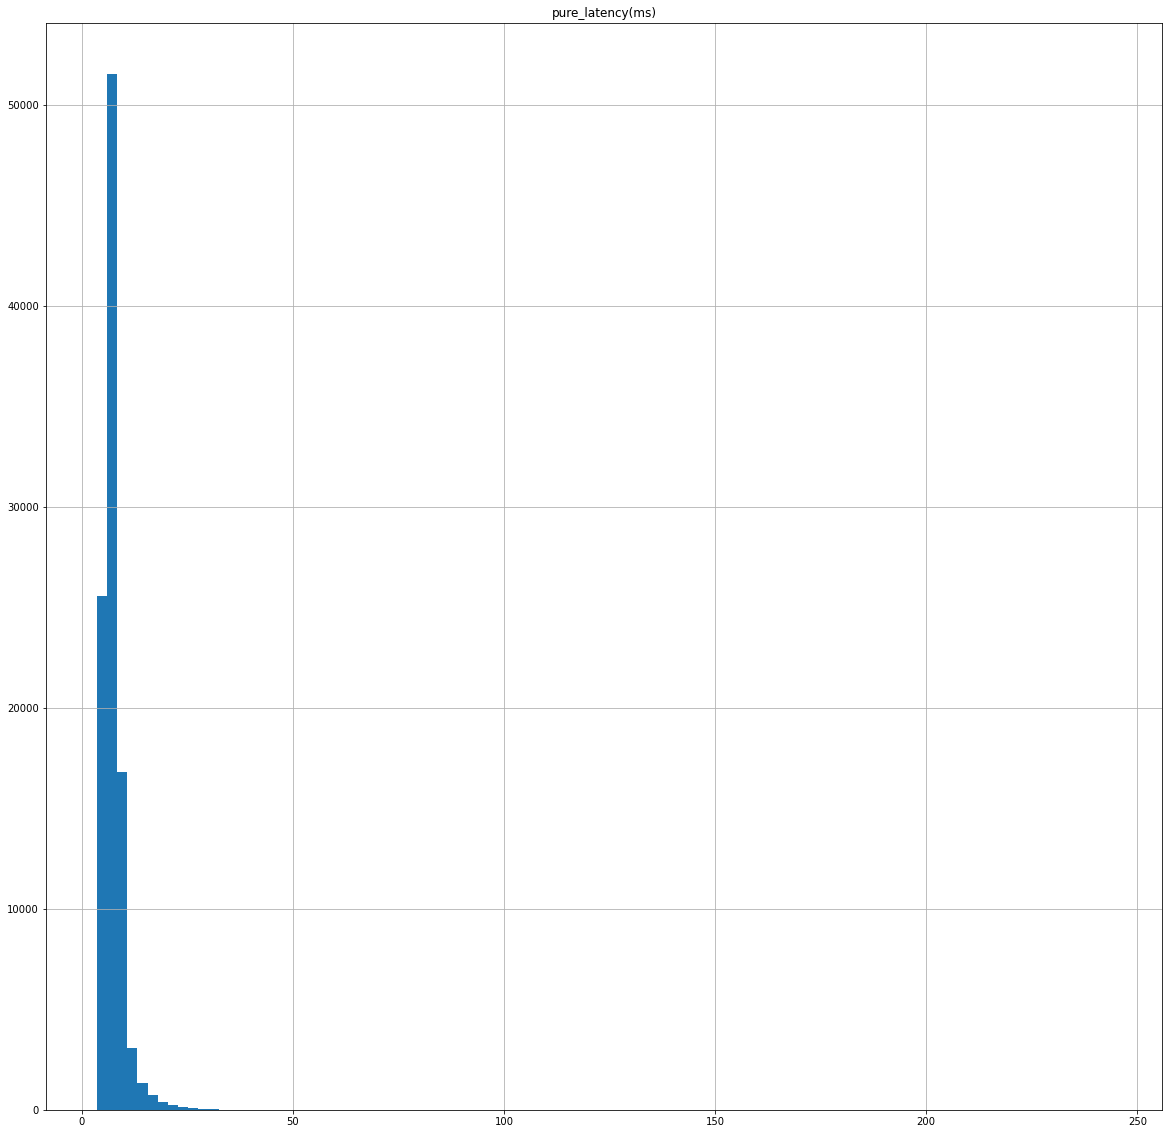

In [8]:
for task, wld in workloads.items():
    wld.plot_load_data(row, "pure_latency(ms)", start, end)
    ax = wld.plot_load_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")

    dfs = wld.get_load_data()
    title = f"{wld.variant} {wld.task_name} insert stats"
    plot_latency_stats(dfs.diff_data, row, title=title, regr="log", start=start, end=end)
    pp.pprint(get_summary_statistics(dfs.diff_data, dfs.fixed_data, dfs.raw_data))


    dfs.diff_data.hist(figsize=(20,20), column= "pure_latency(ms)", bins=100, grid=0.4)

In [ ]:
for task, wld in workloads.items():
    wld.plot_100read_data(row, "pure_latency(ms)", start, end)
    ax = wld.plot_100read_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")

    dfs = wld.get_100read_data()
    title = f"{wld.variant} {wld.task_name} 100read stats"
    plot_latency_stats(dfs.diff_data, row, title=title, regr="log", start=start, end=end)
    pp.pprint(get_summary_statistics(dfs.diff_data, dfs.fixed_data, dfs.raw_data))

In [ ]:
for task, wld in workloads.items():
    wld.plot_95read5update_read_data(row, "pure_latency(ms)", start, end)
    wld.plot_95read5update_write_data(row, "pure_latency(ms)", start, end)
    rdfs = wld.get_95read5update_data()[0]
    wdfs = wld.get_95read5update_data()[1]
    title = f"{wld.variant} {wld.task_name} 95read5update read stats"
    plot_latency_stats(rdfs.diff_data, row, title=title, regr="line", start=start, end=end)
    title = f"{wld.variant} {wld.task_name} 95read5update update stats"
    plot_latency_stats(wdfs.diff_data, row, title=title, regr="line", start=start, end=end)
    pp.pprint(get_summary_statistics(rdfs.diff_data, rdfs.fixed_data, rdfs.raw_data))
    pp.pprint(get_summary_statistics(wdfs.diff_data, wdfs.fixed_data, wdfs.raw_data))

In [ ]:
for task, wld in workloads.items():
    ax = wld.plot_95read5update_read_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")
    ax = wld.plot_95read5update_write_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")

In [ ]:
for task, wld in workloads.items():
    wld.plot_100update_data(row, "pure_latency(ms)", start, end)
    ax = wld.plot_100update_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")

    dfs = wld.get_100update_data()
    title = f"{wld.variant} {wld.task_name} 100update update stats"
    plot_latency_stats(dfs.diff_data, row, title=title, regr="line", start=start, end=end)
    pp.pprint(get_summary_statistics(dfs.diff_data, dfs.fixed_data, dfs.raw_data))

In [ ]:
for task, wld in workloads.items():
    wld.plot_50read50update_read_data(row, "pure_latency(ms)", start, end)
    wld.plot_50read50update_write_data(row, "pure_latency(ms)", start, end)
    rdfs = wld.get_50read50update_data()[0]
    wdfs = wld.get_50read50update_data()[1]
    title = f"{wld.variant} {wld.task_name} 50read50update read stats"
    plot_latency_stats(rdfs.diff_data, row, title=title, regr="line", start=start, end=end)
    title = f"{wld.variant} {wld.task_name} 50read50update update stats"
    plot_latency_stats(wdfs.diff_data, row, title=title, regr="line", start=start, end=end)
    pp.pprint(get_summary_statistics(rdfs.diff_data, rdfs.fixed_data, rdfs.raw_data))
    pp.pprint(get_summary_statistics(wdfs.diff_data, wdfs.fixed_data, wdfs.raw_data))

In [ ]:
for task, wld in workloads.items():
    ax = wld.plot_50read50update_read_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")
    ax = wld.plot_50read50update_write_data("ts", "throughput", True, start, end, ylabel="throughput (ops/sec)")